<a href="https://colab.research.google.com/github/pachterlab/CP_2022/blob/main/notebooks/picassoAnalysis/kimetal_smartseq_picasso_l2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import os

from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#smartseq VMH data
#metadata.csv
download_file('10.22002/D1.2067','.gz')

#smartseq.mtx (log counts)
download_file('10.22002/D1.2071','.gz')



os.system("gunzip *.gz")

os.system("mv D1.2067 metadata.csv")
os.system("mv D1.2071 smartseq.mtx")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/64 [00:00<?, ?B/s]

  0%|          | 0/26700 [00:00<?, ?B/s]

0

In [2]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 145 (delta 3), reused 2 (delta 2), pack-reused 137
Receiving objects: 100% (145/145), 419.61 KiB | 4.15 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [3]:
%cd /content/densvis/densne/

/content/densvis/densne


In [4]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [5]:
%cd /content/

/content


In [6]:
!git clone https://github.com/pachterlab/CP_2022.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 518 (delta 50), reused 27 (delta 9), pack-reused 424
Receiving objects: 100% (518/518), 180.53 MiB | 25.19 MiB/s, done.
Resolving deltas: 100% (263/263), done.
Checking out files: 100% (61/61), done.


In [7]:
%cd /content/CP_2022/scripts

/content/CP_2022/scripts


In [8]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn

     |████████████████████████████████| 96 kB 2.3 MB/s 
     |████████████████████████████████| 7.7 MB 5.1 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 88 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 60.8 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 


## **Install Packages**

In [24]:
import anndata 
import pandas as pd
import numpy as np

import visualizations as vis
import tools as tl
from Picasso import Picasso
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [10]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

pcs = 50
n_latent = 50

In [11]:
count_mat = sio.mmread(data_path+'/smartseq.mtx')
count_mat.shape

(3850, 1999)

In [12]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [13]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

,sample_name,smartseq_cluster_id,smartseq_cluster,sex_label,smartseq_cluster_color,medical_cond_label,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
SM-GE4R2_S062_E1-50,SM-GE4R2_S062_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,964371.56,9772,0.0,True,True
SM-GE4SI_S356_E1-50,SM-GE4SI_S356_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,973072.06,8253,0.0,True,True
SM-GE4SI_S172_E1-50,SM-GE4SI_S172_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,977132.60,9394,0.0,True,True
LS-15034_S07_E1-50,LS-15034_S07_E1-50,42,Nr5a1_4|7 Glipr1,M,#763BFF,behavior - none,948605.44,10643,0.0,True,True
LS-15034_S28_E1-50,LS-15034_S28_E1-50,42,Nr5a1_4|7 Glipr1,F,#763BFF,behavior - none,951803.00,10550,0.0,True,True


In [14]:
print(meta.sex_label.value_counts()[0]/meta.sex_label.value_counts()[1])
print(meta.sex_label.value_counts()[1])

7.406113537117904
458


In [15]:
lab1 = list(meta.smartseq_cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.medical_cond_label)


allLabs = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))  
shuff_lab2 = random.sample(lab2, len(lab2))  
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.smartseq_cluster_color))

sex_colors = ['#abacb7','#F8C471']

Set Ambient Data

In [16]:
amb = tl.getCentroidDists(count_mat,meta.smartseq_cluster,m='l2')
ambIntra = tl.getIntraVar(count_mat, meta.smartseq_cluster, meta.sex_label,m='l2')
ambIntraC = tl.getIntraVar(count_mat, meta.smartseq_cluster, meta.smartseq_cluster,m='l2')
ambInter = tl.getInterVar(count_mat, meta.smartseq_cluster, meta.sex_label,m='l2')

In [17]:
def getAllVars(latents,latentLab,latentType):
  '''Get all intra- and inter-distances for input latent space, and Pearson 
  correlation of those distances to ambient space'''
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
    d = latentType[p]

    c = tl.getCentroidDists(i, meta.smartseq_cluster,m='l2')
    intra = tl.getIntraVar(i, meta.smartseq_cluster, meta.sex_label,m='l2')
    intraC = tl.getIntraVar(i, meta.smartseq_cluster, meta.smartseq_cluster,m='l2')
    inter = tl.getInterVar(i, meta.smartseq_cluster, meta.sex_label,m='l2')

    vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0], stats.pearsonr(intraC, ambIntraC)[0], stats.pearsonr(inter, ambInter)[0]]
    dist += ['Inter-Type','Intra-Sex','Intra-Type','Inter-Sex'] 

    emb += [l]*4
    dim += [d]*4


  allVals['Latent'] = emb
  allVals['Distance'] = dist
  allVals['Pearsonr'] = vals
  allVals['Dimension'] = dim


  return allVals


In [18]:
orig_indices = tl.getNeighbors(count_mat, n_neigh = 10,p=2)

In [27]:
# def getAllKNNs(latents,latentLab,latentType,n_neigh=10,p=1):
#   emb = []

#   frac = []


#   knnDF = pd.DataFrame()

#   for p in range(len(latents)):
#     i = latents[p]
#     l = latentLab[p]

#     ind = tl.getNeighbors(i, n_neigh = n_neigh,p=p)

#     frac += [np.mean(tl.getIntersect(orig_indices,ind))]



#     emb += [l]


#   knnDF['Fraction'] = frac
#   knnDF['Latent'] = emb

#   return knnDF

In [19]:
def getJac(orig_indices,latents, latentLab, n_neighbors=30,set_p=1):
  emb = []

  xs = []

  ys = []

  knnDF = pd.DataFrame()

  for p in range(len(latents)):
    i = latents[p]
    l = latentLab[p]

    ind = tl.getNeighbors(i, n_neigh = n_neighbors,p=set_p)

    x = tl.getJaccard(orig_indices,ind)

    xs += x
    #ys += list(y)

    emb += [l]*len(x)

    print(l)

    print(np.mean(tl.getJaccard(orig_indices,ind)))



  knnDF['x'] = xs
  #knnDF['y'] = ys
  knnDF['latent'] = emb

  return knnDF

### **Picasso Analysis**

In [20]:
rounds = 5 #3 for Picasso KNN
#seeds = [1,2,3,4,42]

In [21]:
# rounds = 3

In [22]:
batch_size = 128 #3850
#Make a (unit) circle 
#r = 1
theta = np.linspace(0, 2*np.pi, batch_size)
# #Turkey guy
# x, y = (np.sin(2**theta) - 1.7) * np.cos(theta), (np.sin(2**theta) - 1.7) * np.sin(theta)

# #Butterfly r = 4*cos(4cosθ))
# x, y = (2*np.cos(4*np.cos(theta))) * np.cos(theta), (2*np.cos(4*np.cos(theta))) * np.sin(theta)

# # Spiral
#x, y = (1/2)*theta * np.cos(theta), (1/2)*theta * np.sin(theta)

# #Quasi-rose
x, y = (4 + np.cos(6*theta)) * np.cos(theta), (4 + np.cos(6*theta)) * np.sin(theta)


#Make array input for dimension of shape 
coords = np.array([list(x),list(y)])

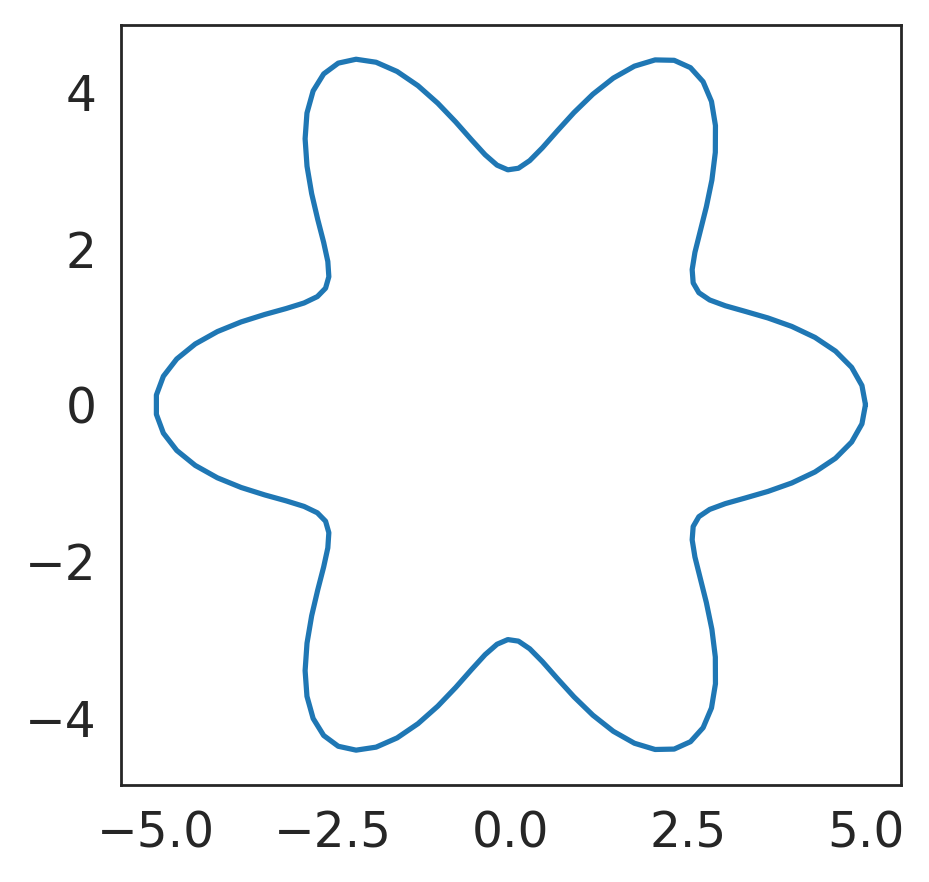

In [25]:
plt.plot(x,y)

In [26]:
#Task assignment code
fl = []
flLab = []
flType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs = 500, batch_size = batch_size) #100
  losses1, latent1 = nca.fit(scaled_mat,coords, frac = 0.2,silent=True,ret_loss=True)

  fl += [latent1]
  flLab += ['Flower']
  flType += ['MCML 2D']






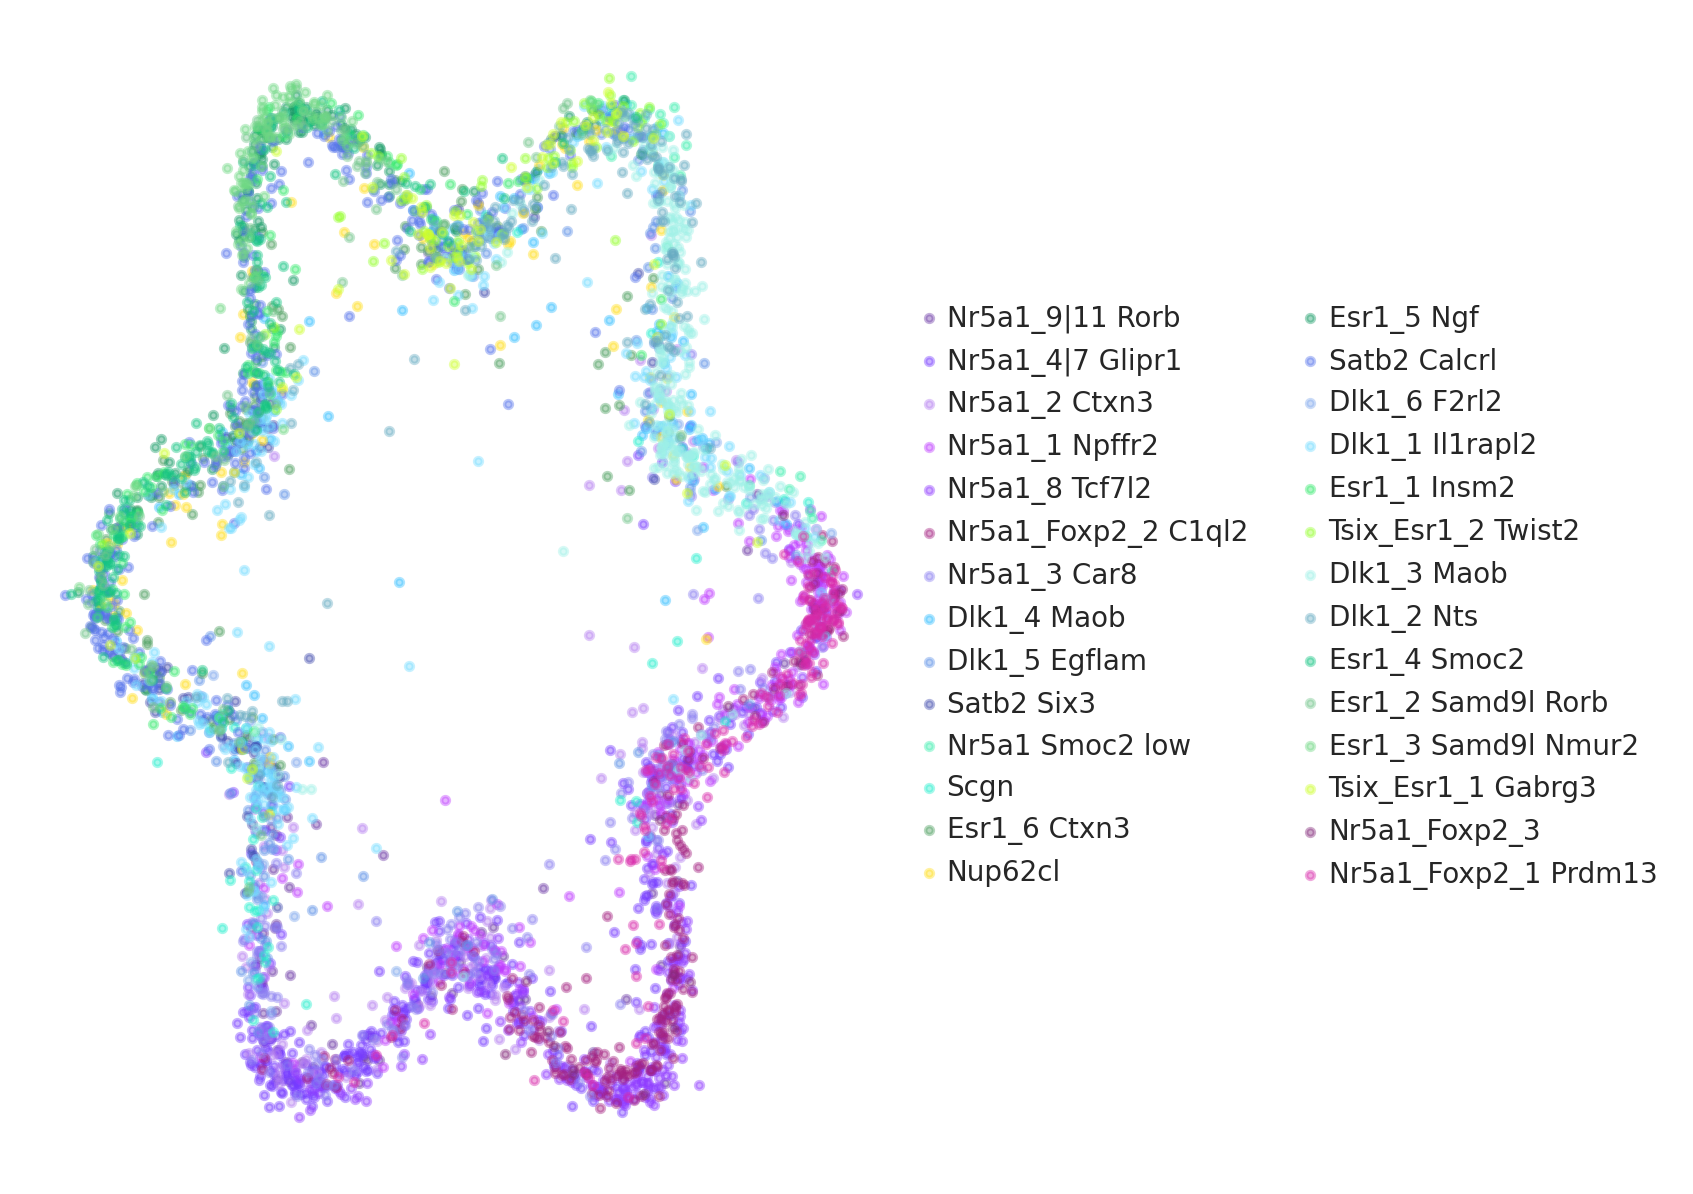

In [25]:
vis.obj_plot_embed(latent1, meta.smartseq_cluster, fname = '2DNCA.pdf', colors=clus_colors )

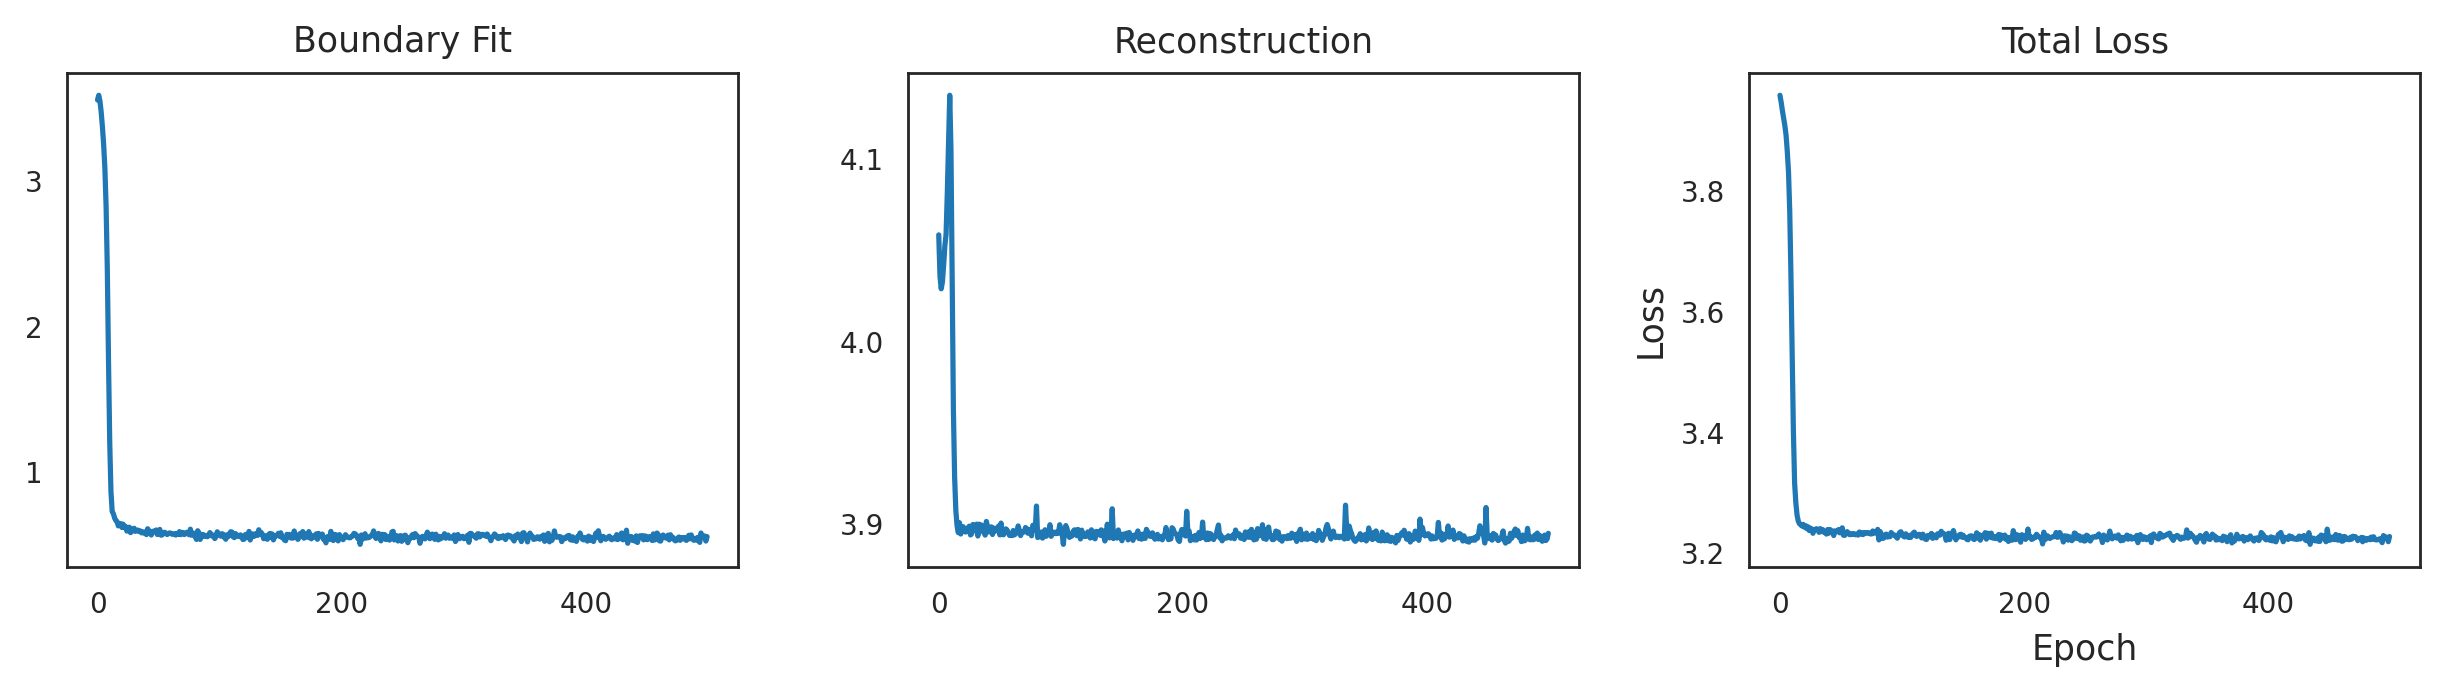

In [27]:
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

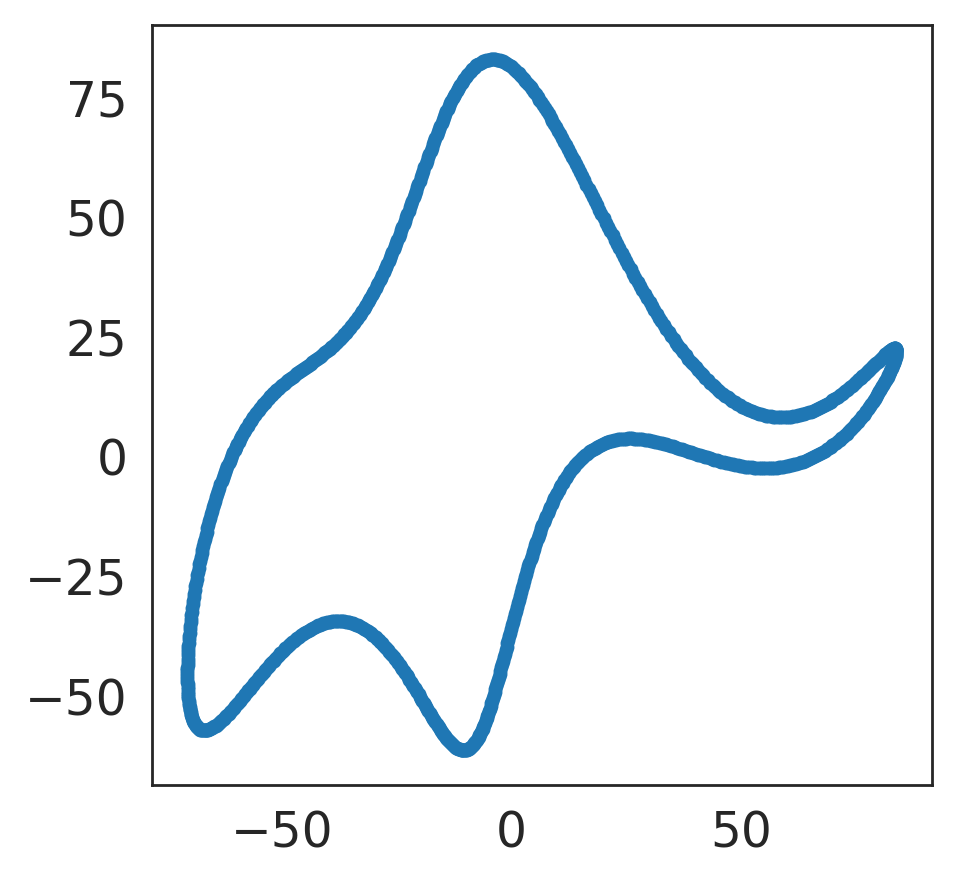

In [28]:
# elephant parameters
batch_size = 1000 #500 #128 #3850 # 50000 for old code, 3850 for task assignment

p1, p2, p3, p4 = (50 - 30j, 18 +  8j, 12 - 10j, -14 - 60j )
p5 = 40 + 20j # eyepiece

def fourier(t, C):
    f = np.zeros(t.shape)
    A, B = C.real, C.imag
    for k in range(len(C)):
        f = f + A[k]*np.cos(k*t) + B[k]*np.sin(k*t)
    return f

def elephant(t, p1, p2, p3, p4, p5):
    npar = 6
    Cx = np.zeros((npar,), dtype='complex')
    Cy = np.zeros((npar,), dtype='complex')

    Cx[1] = p1.real*1j
    Cx[2] = p2.real*1j
    Cx[3] = p3.real
    Cx[5] = p4.real

    Cy[1] = p4.imag + p1.imag*1j
    Cy[2] = p2.imag*1j
    Cy[3] = p3.imag*1j

    # x = np.append(fourier(t,Cx), [-p5.imag]) #[-p5.imag]
    # y = np.append(fourier(t,Cy), [p5.imag]) #[p5.imag]
    x = fourier(t,Cx)
    y = fourier(t,Cy)

    return x,y

x, y = elephant(np.linspace(0,2*np.pi,batch_size), p1, p2, p3, p4, p5)

#Make array input for dimension of shape 

y = y#0.03*y
x = x#0.02*x

coords = np.array([list(y),list(-x)])

plt.plot(y,-x,'.')
plt.show()


In [69]:
#Task assign
#batch_size = 3850 
rounds = 5
el = []
elLab = []
elType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs = 500, batch_size = batch_size)
  lossesEl, latentEl = nca.fit(scaled_mat,coords, frac = 0.15,silent=True,ret_loss=True) #.15, 0.04, 0.2 with 1000 pts

  el += [latentEl]
  elLab += ['Elephant']
  elType += ['MCML 2D']




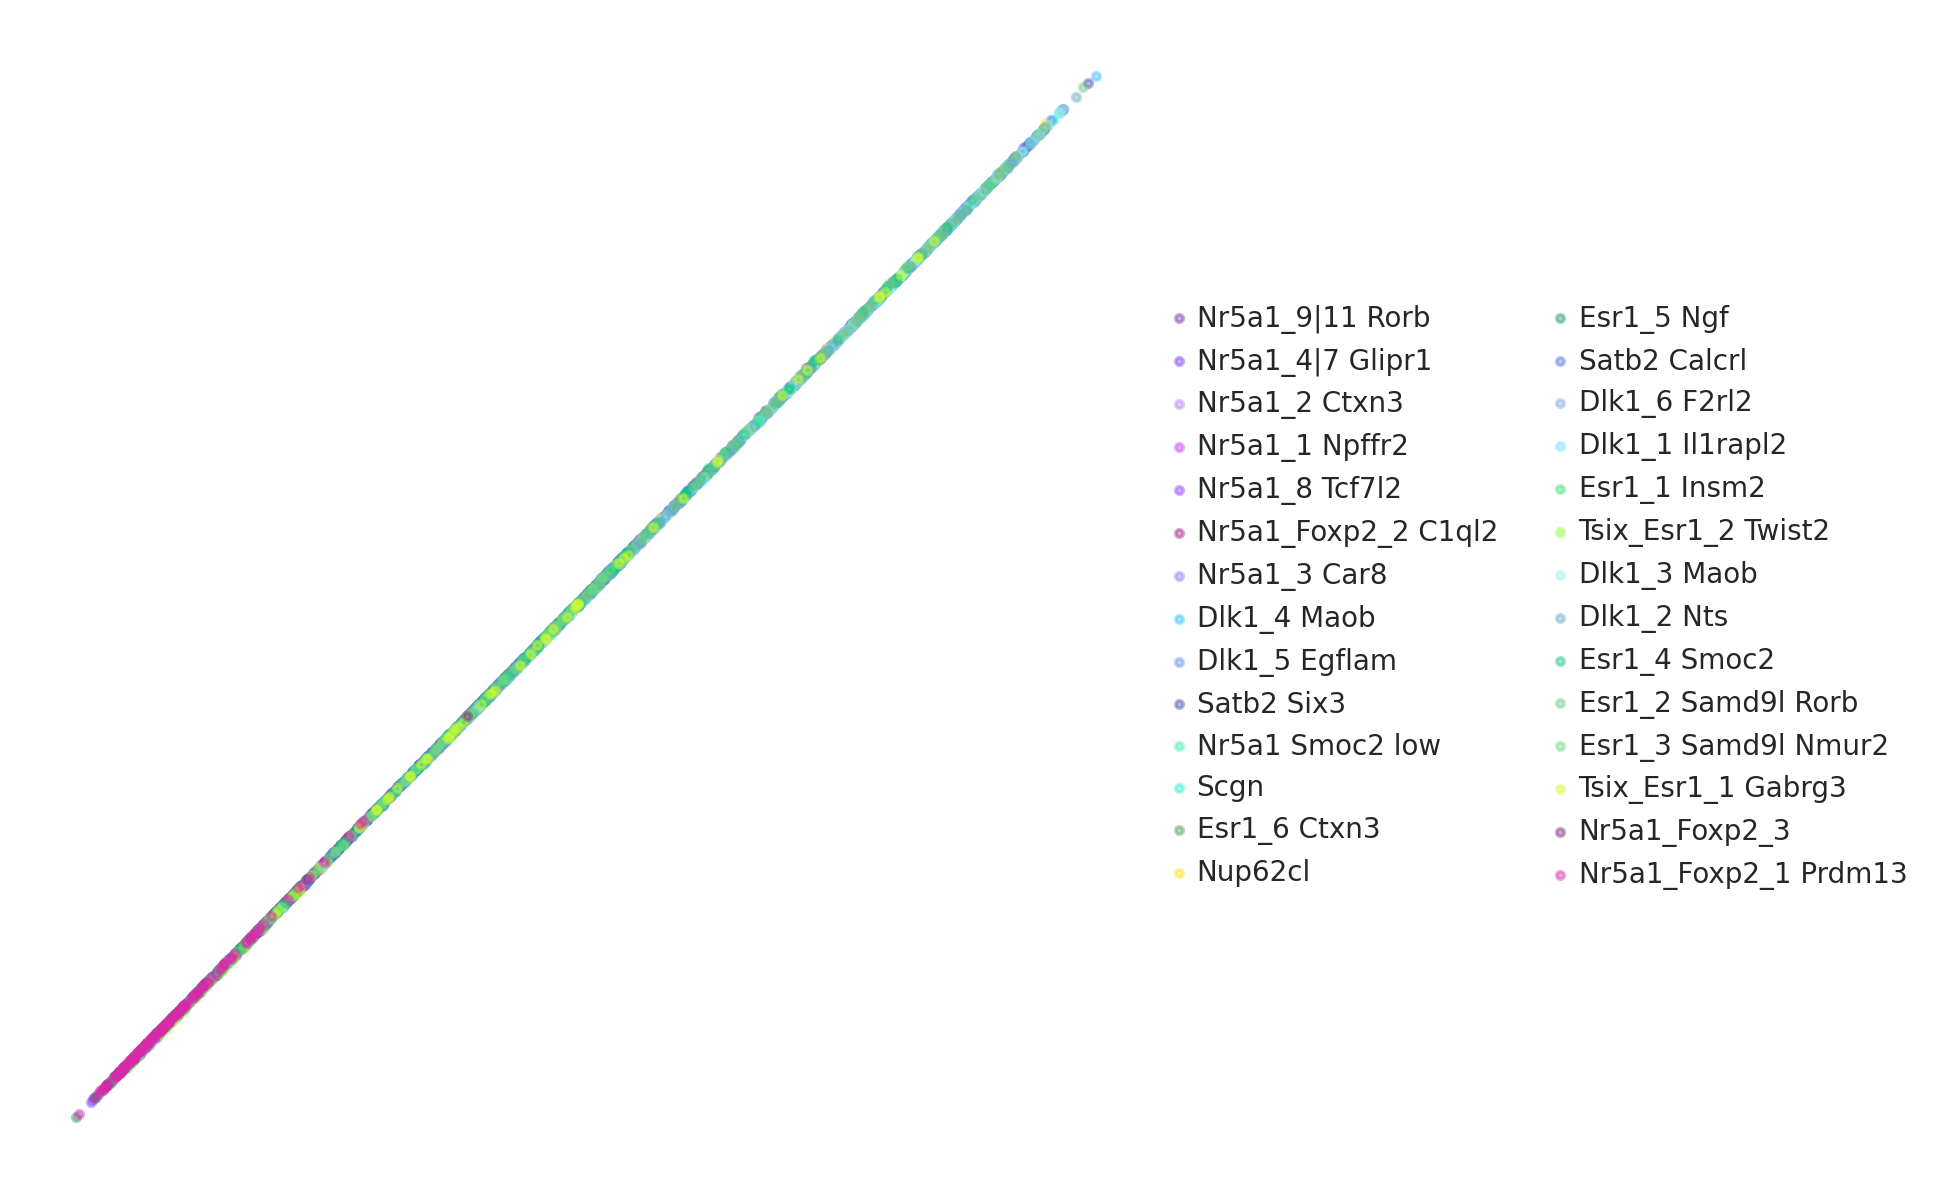

In [70]:
vis.obj_plot_embed(latentEl, meta.smartseq_cluster, fname = '2DNCA.pdf', colors=clus_colors ,figsize=(8,5))

Save KNN Jaccard Distances

In [29]:
orig_indices = tl.getNeighbors(count_mat, n_neigh = 30,p=2)

In [36]:
df = getJac(orig_indices,fl+el, flLab+elLab, 30,2)
df.to_csv('smartPicAmb.csv')

Flower
0.9441424282781309
Flower
0.954495535085077
Flower
0.9499508112385535
Flower
0.9556908467063812
Flower
0.9526577897263899
Elephant
0.9653236452990369
Elephant
0.9592960888222417
Elephant
0.9645835123069962
Elephant
0.9728219517136418
Elephant
0.9711622693435029


In [37]:
from google.colab import files
files.download("smartPicAmb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

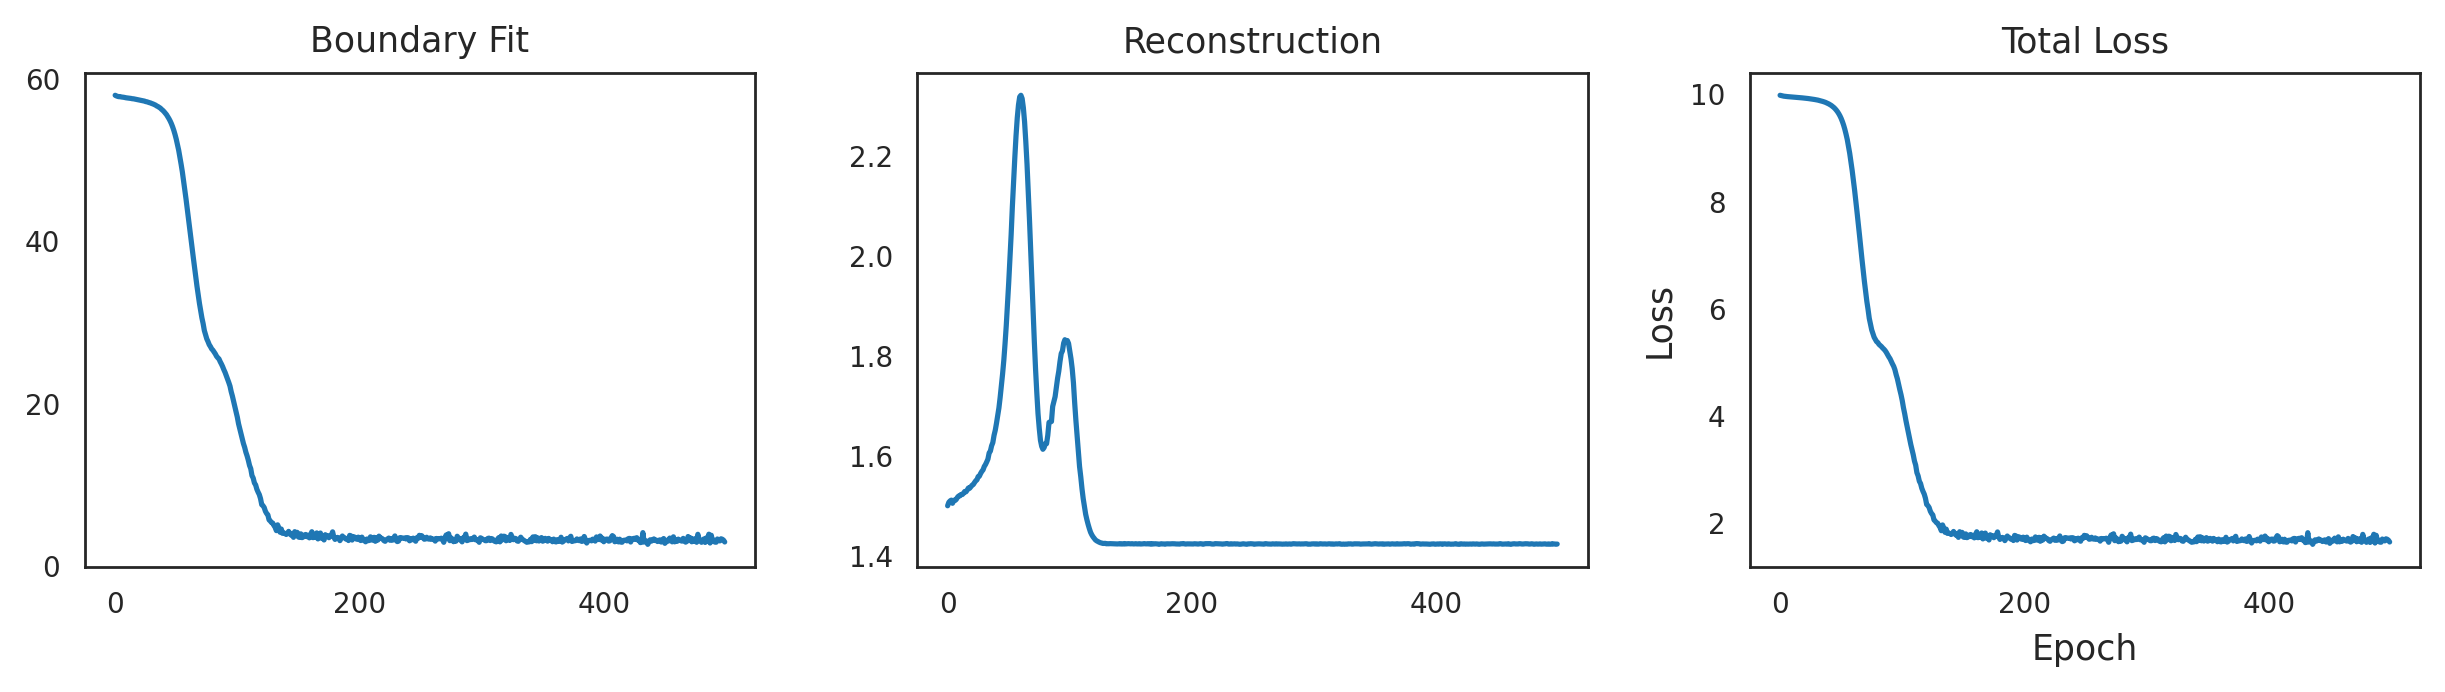

In [ ]:
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

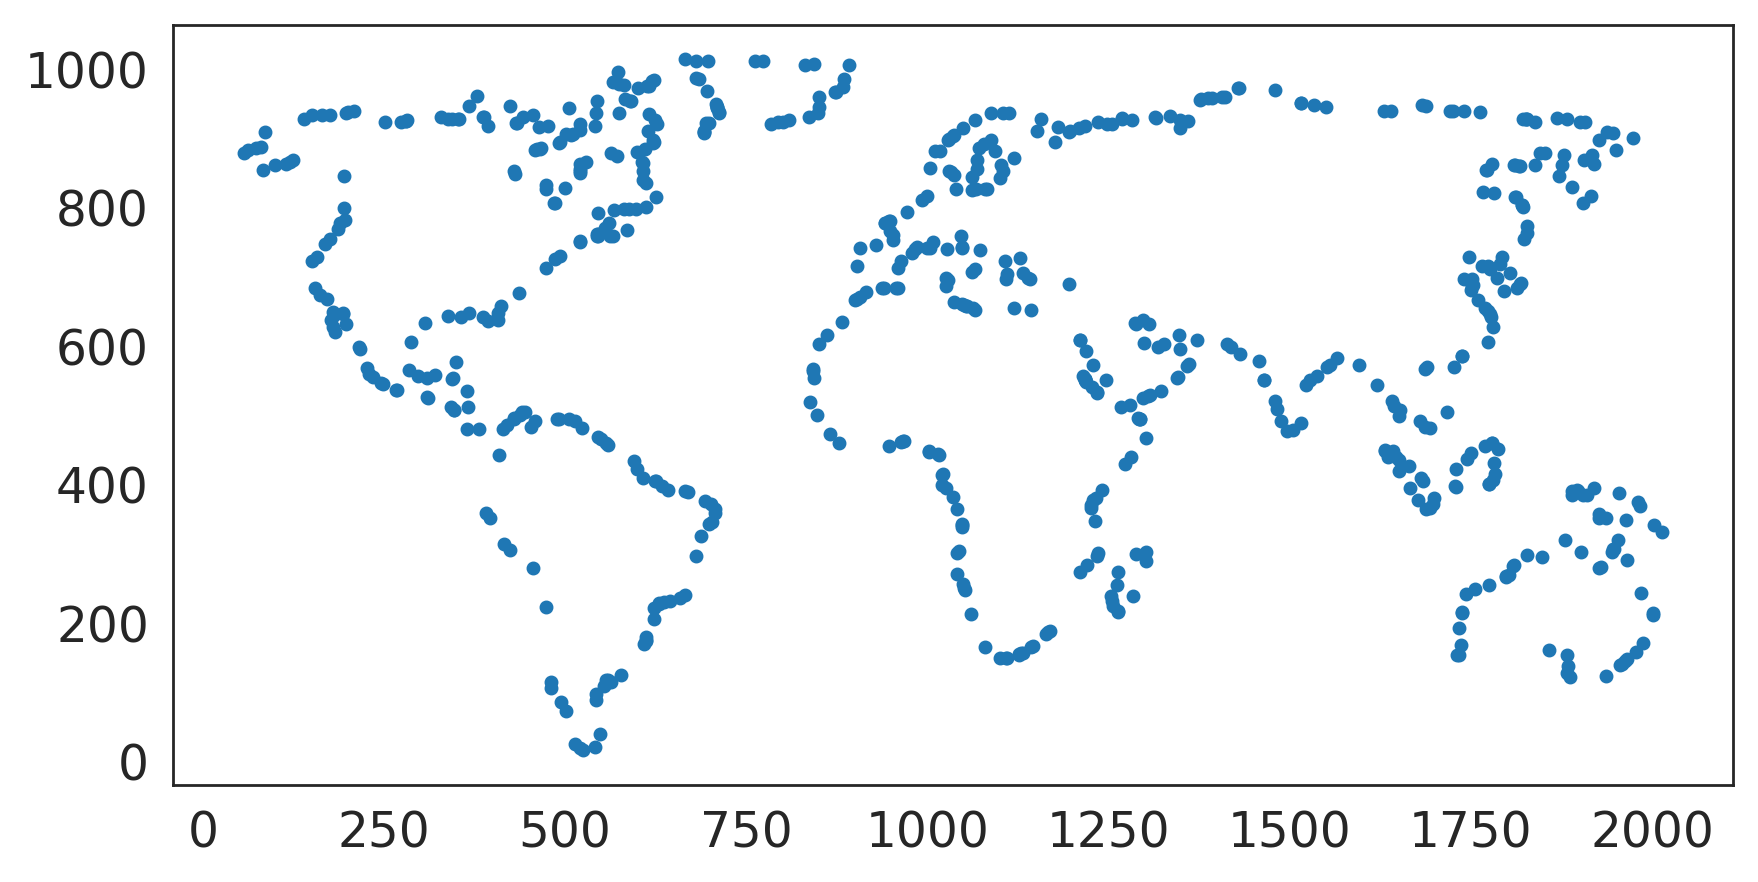

In [30]:
# Map parameters
pts = pd.read_csv('../data/mapPoints700.csv',header=None)
pts.head()

x = pts[0]
y = pts[1]
coords = np.array([x,y])

plt.figure(figsize=(8,4))
plt.plot(x,y,'.')
plt.show()


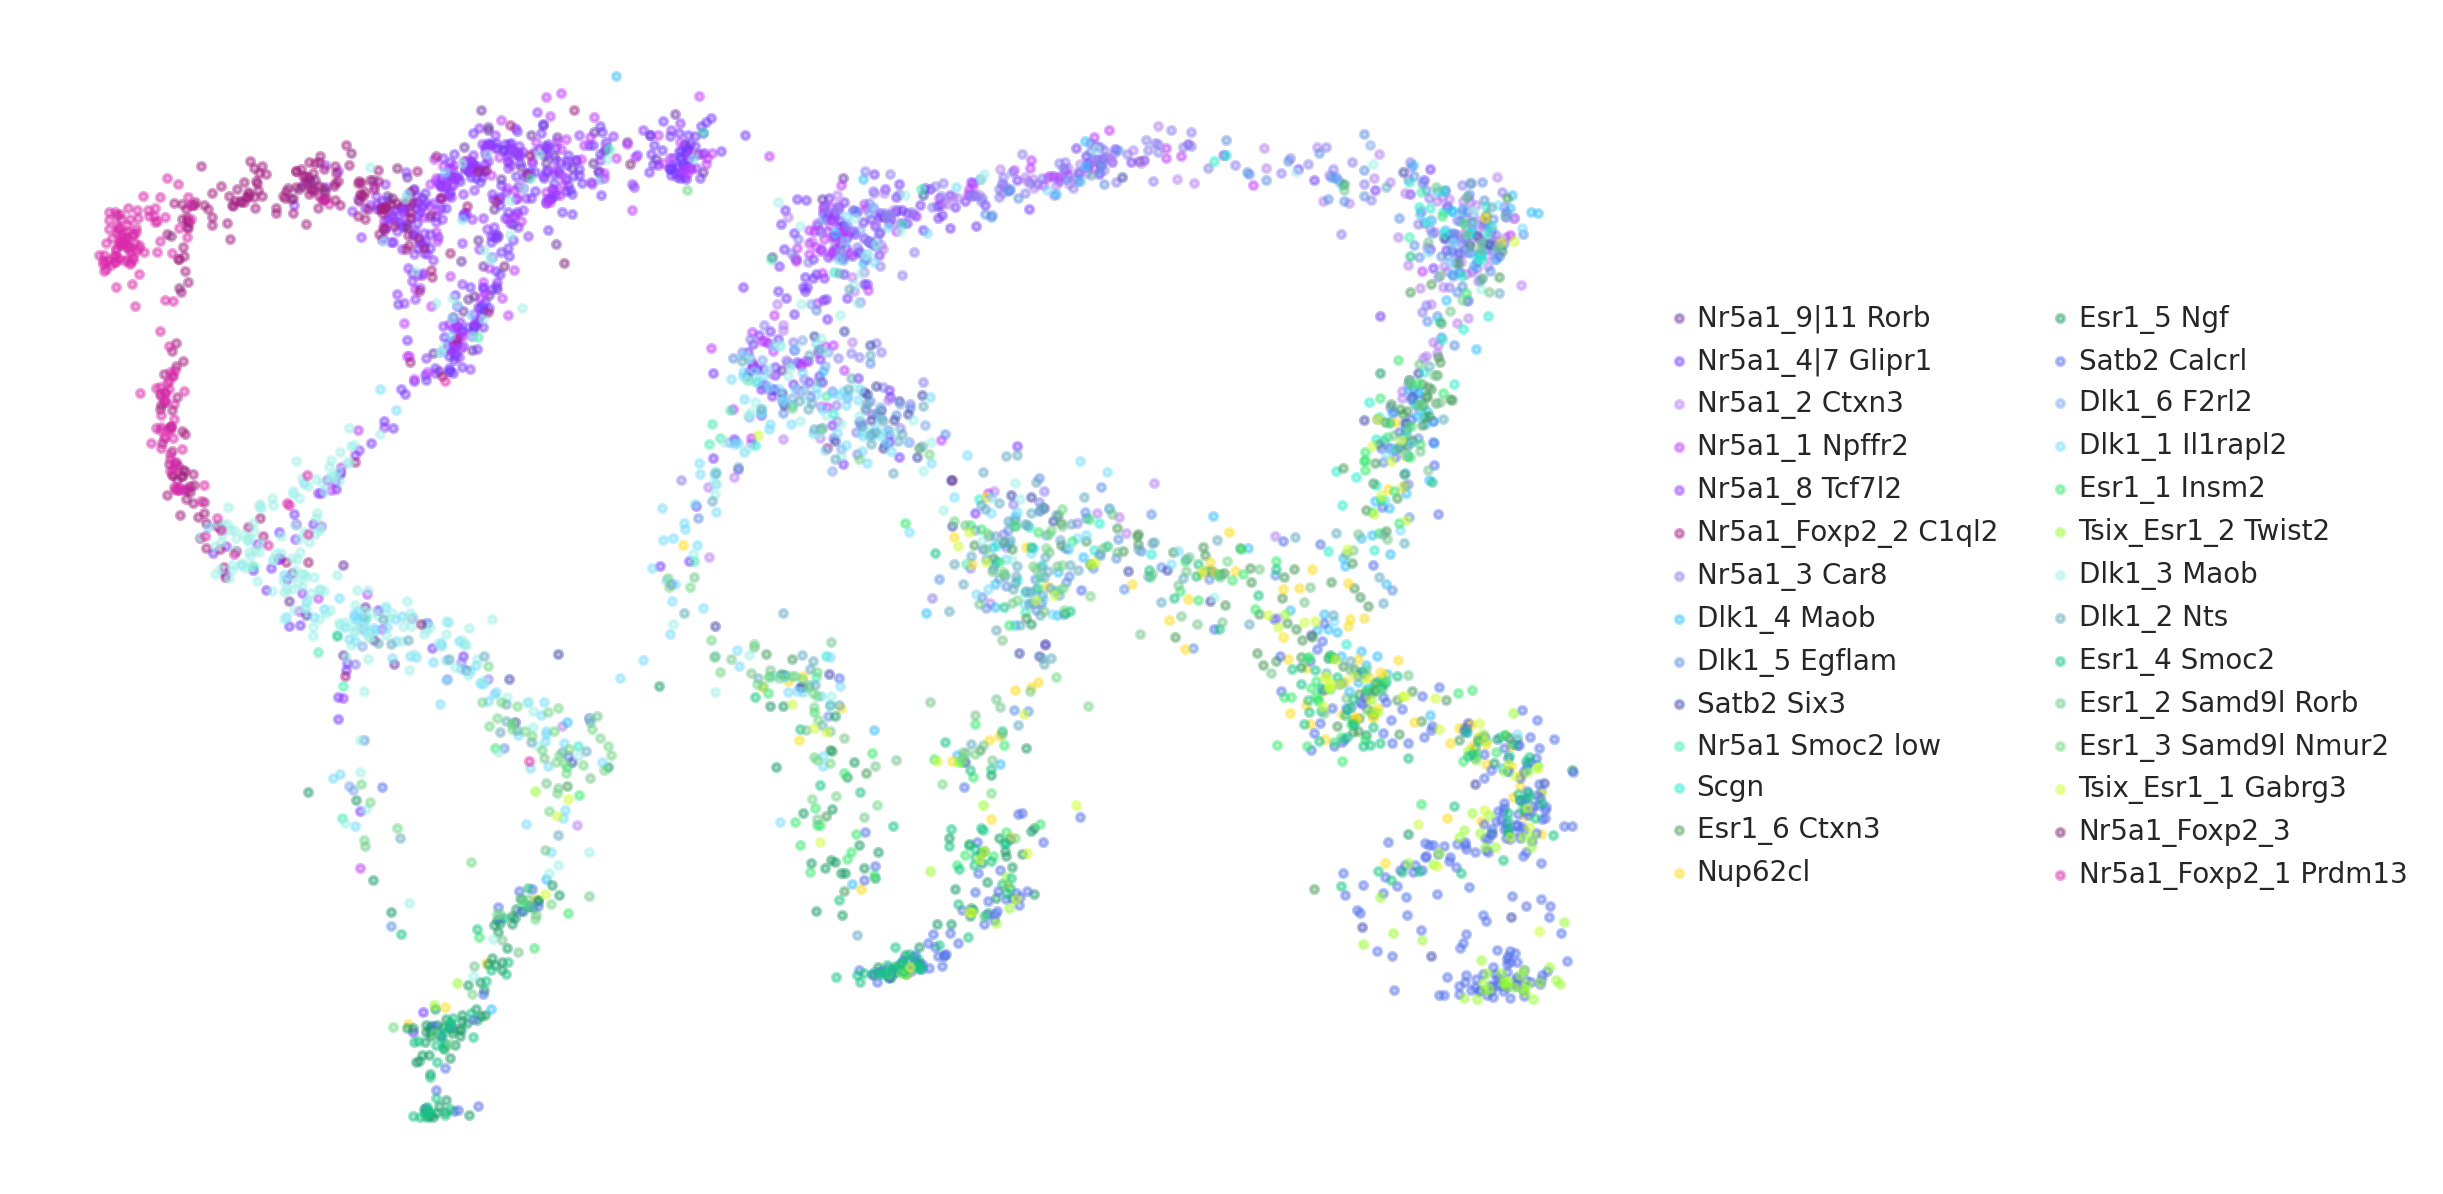

In [31]:
#Test with task assignment in-utero 
batch_size = len(x)
rounds = 5

map = []
mapLab = []
mapType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs = 1000, batch_size = batch_size)
  lossesMap, latentMap = nca.fit(scaled_mat,coords, frac = 0.44,silent=True,ret_loss=True) #44

  map += [latentMap]  
  mapLab += ['Map']
  mapType += ['MCML 2D']


vis.obj_plot_embed(latentMap, allLabs[0], fname = '2DNCA.pdf', colors=clus_colors,figsize=(10,5) )


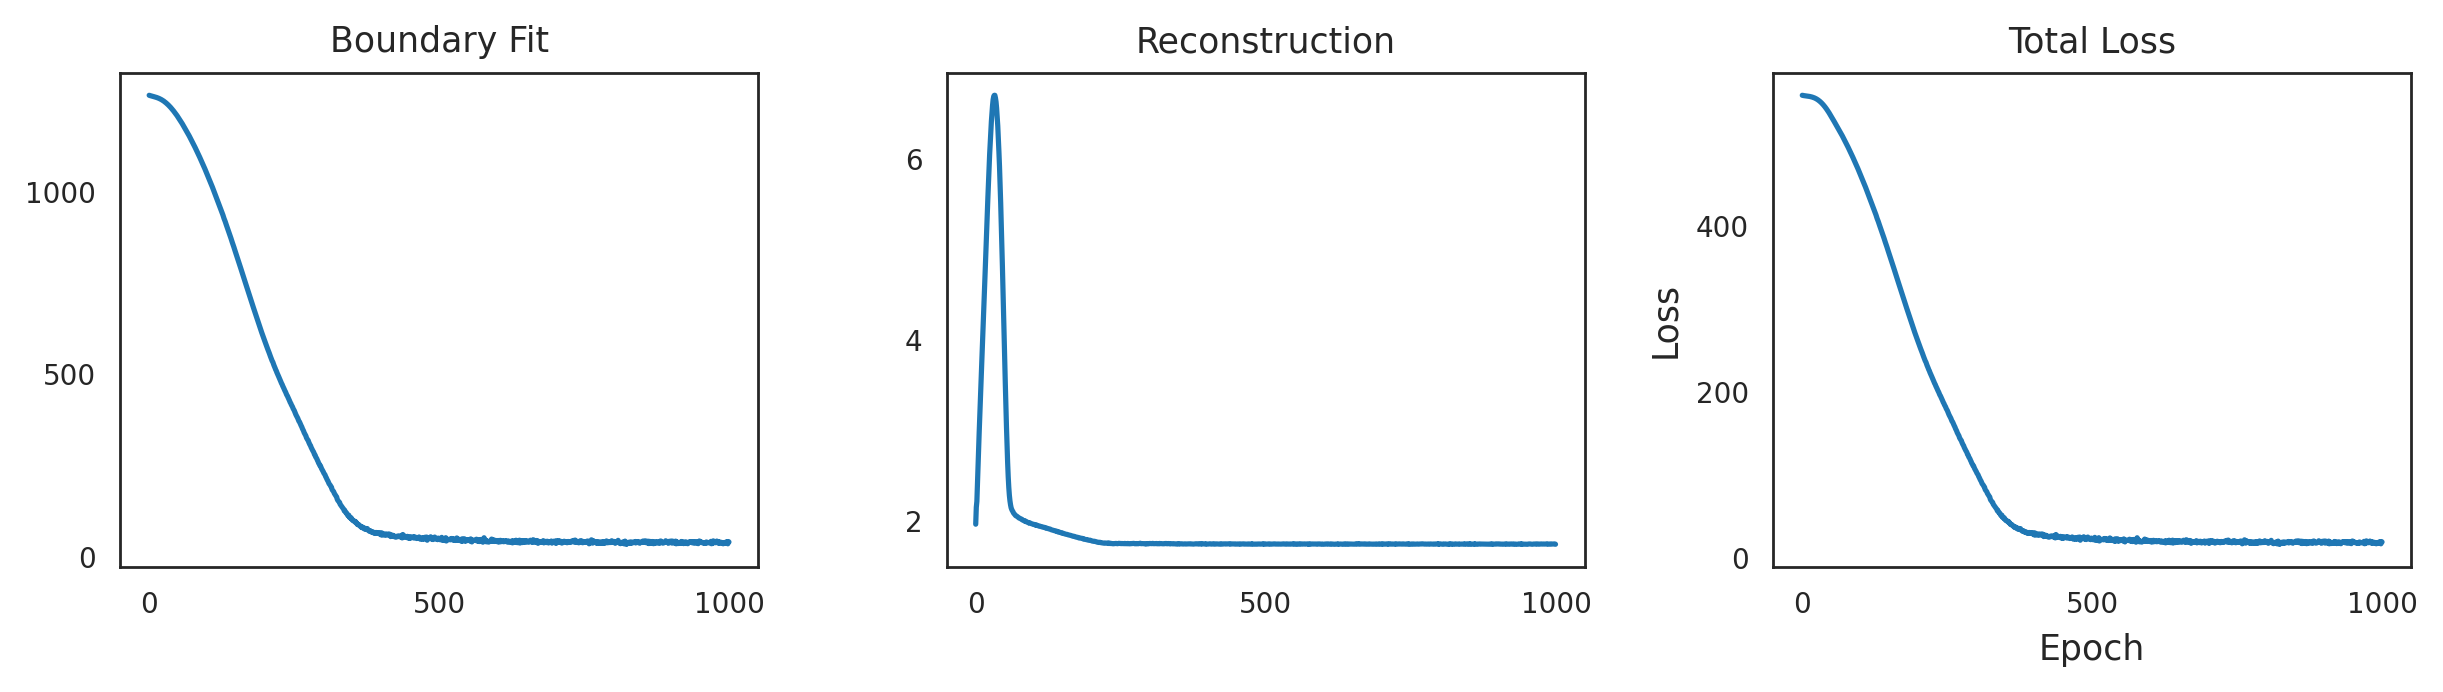

In [ ]:
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

In [32]:
# #Try with no learning
#batch_size = len(x)
rounds = 5

noT = []
noTLab = []
noTType = []

for i in range(rounds):

  nca = Picasso(n_latent = 2, epochs = 0 ) #batch_size = batch_size
  lossesNoT, latentNoT = nca.fit(scaled_mat,coords, frac = 1,silent=True,ret_loss=True)

  noT += [latentNoT]  
  noTLab += ['No Training']
  noTType += ['Picasso 2D']



# vis.obj_plot_embed(latentNoT, meta.smartseq_cluster, fname = '2DNCA.pdf', colors=clus_colors )


Get Latent Space Comparisons (Baselines)

In [32]:
latents,latentLab,latentType = tl.visComp(scaled_mat, ndims=2, pcs=50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

In [33]:
def plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, errwidth=1, figsize =(8,4), dodge=0.4, fname = None):
	plt.figure(figsize=figsize)
	g=sns.pointplot(x='Distance', y='Pearsonr', data=allVals, hue='Latent', err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=dodge)
	plt.setp(g.collections, alpha=.6) #for the markers
	plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})

	

	plt.xlabel("Distance Metric",fontsize=axisFontSize)
	plt.ylabel("Pearsonr (to Ambient)",fontsize=axisFontSize)
	plt.xticks(fontsize=tickFontSize)
	plt.yticks(fontsize=tickFontSize)
	plt.tight_layout()

	if(fname != None):
		plt.savefig(fname)
	else:
		plt.show()

Compare no training

In [69]:
latentsnoT = noT + latents

latentLabnoT = noTLab + latentLab

latentTypenoT = noTType + latentType

In [70]:
allVals = getAllVars(latentsnoT,latentLabnoT,latentTypenoT )
allVals = allVals[~allVals['Latent'].isin(['PCA 50D'])]

In [71]:
allVals['Latent'] = [i.replace('TSNE','t-SNE') for i in allVals['Latent']]
allVals['Latent'] = [i.replace('densSNE','dens-SNE') for i in allVals['Latent']]

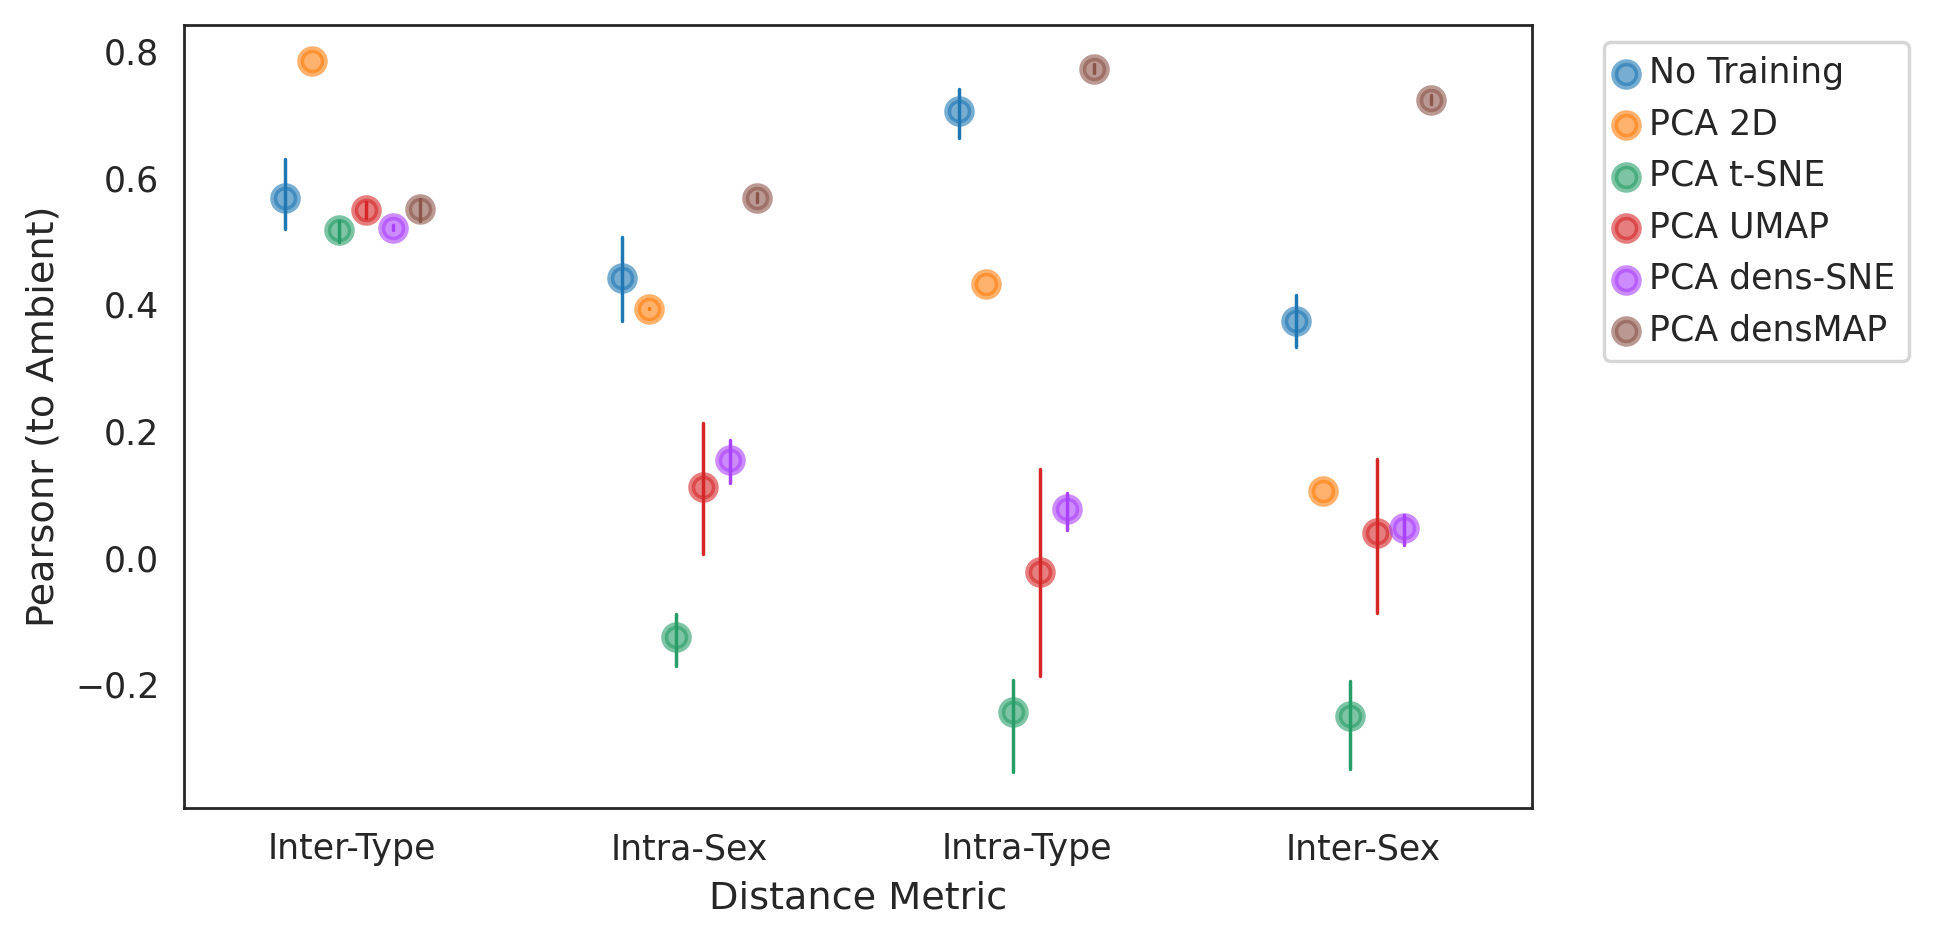

In [72]:
plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10)

Compare Flower Embedding Accuracy

In [34]:
latents = fl + latents

latentLab = flLab + latentLab

latentType = flType + latentType

In [35]:
allVals = getAllVars(latents,latentLab,latentType)
allVals = allVals[~allVals['Latent'].isin(['PCA 50D','Elephant'])]

In [36]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP','PCA 50D']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

In [37]:
toRemove = ['Intra-Sex','Inter-Sex']
subDistAllVals = subAllVals[~subAllVals['Distance'].isin(toRemove)]

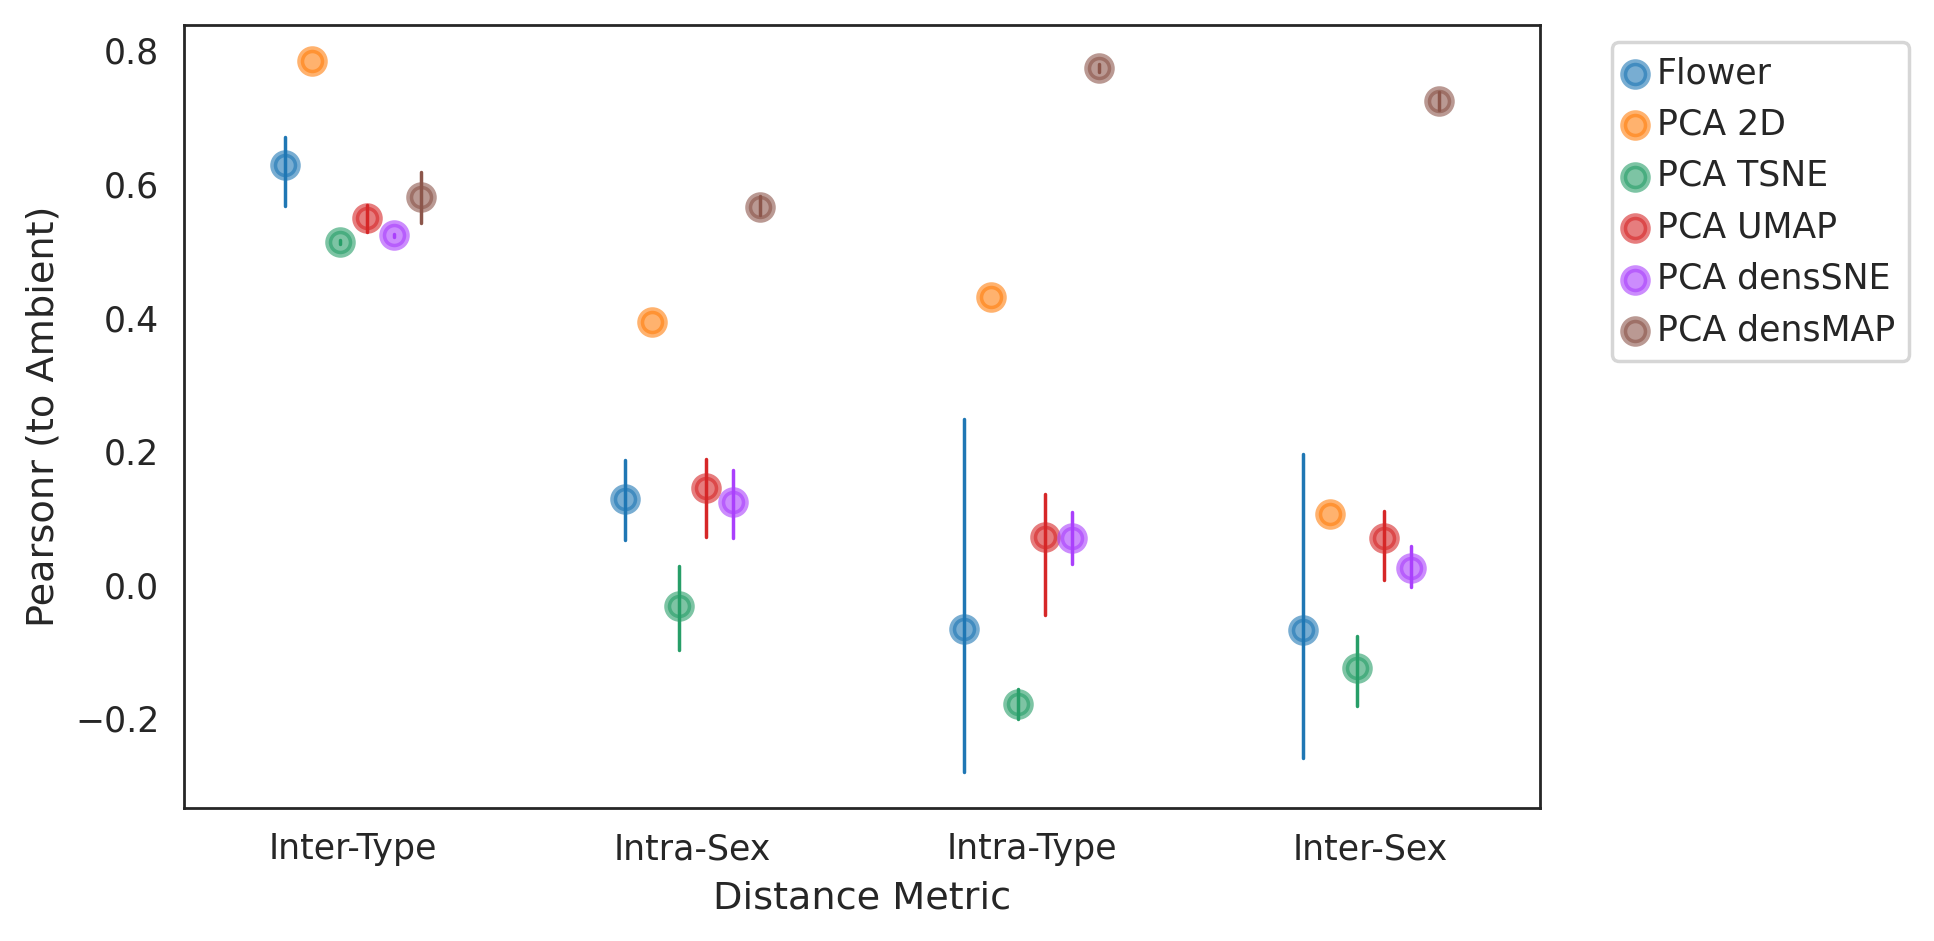

In [38]:
plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10)

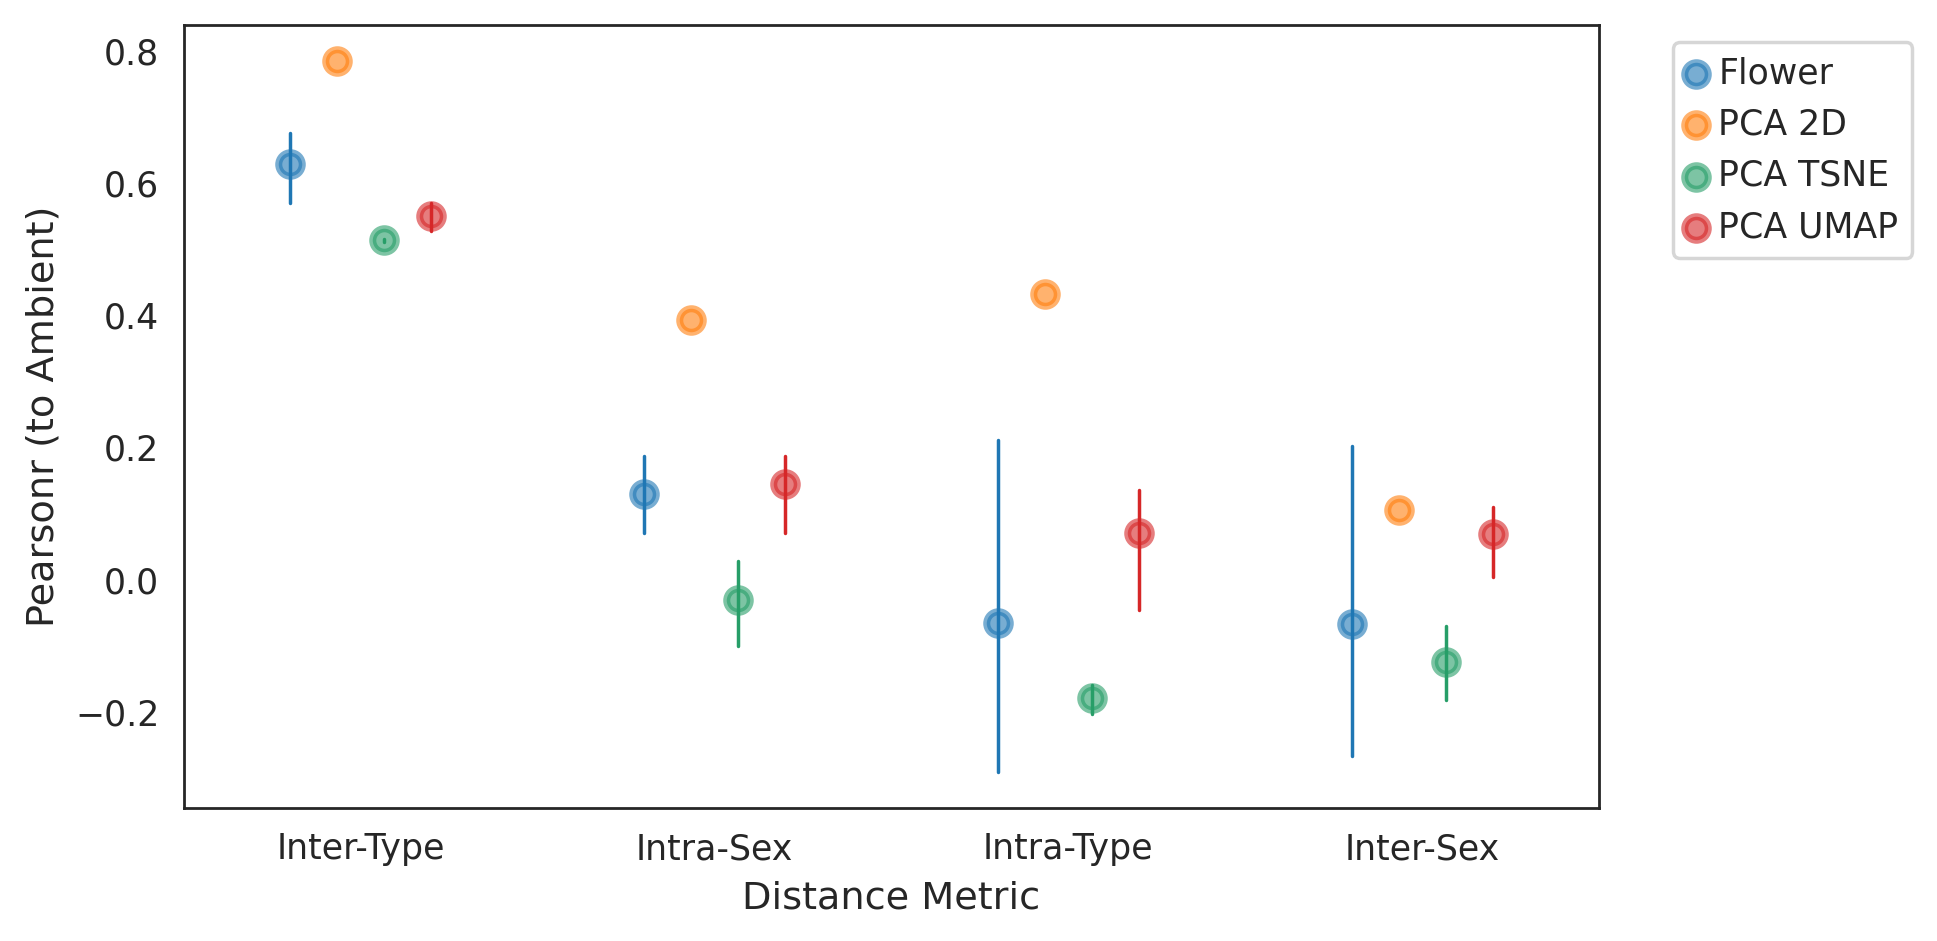

In [39]:
plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10)

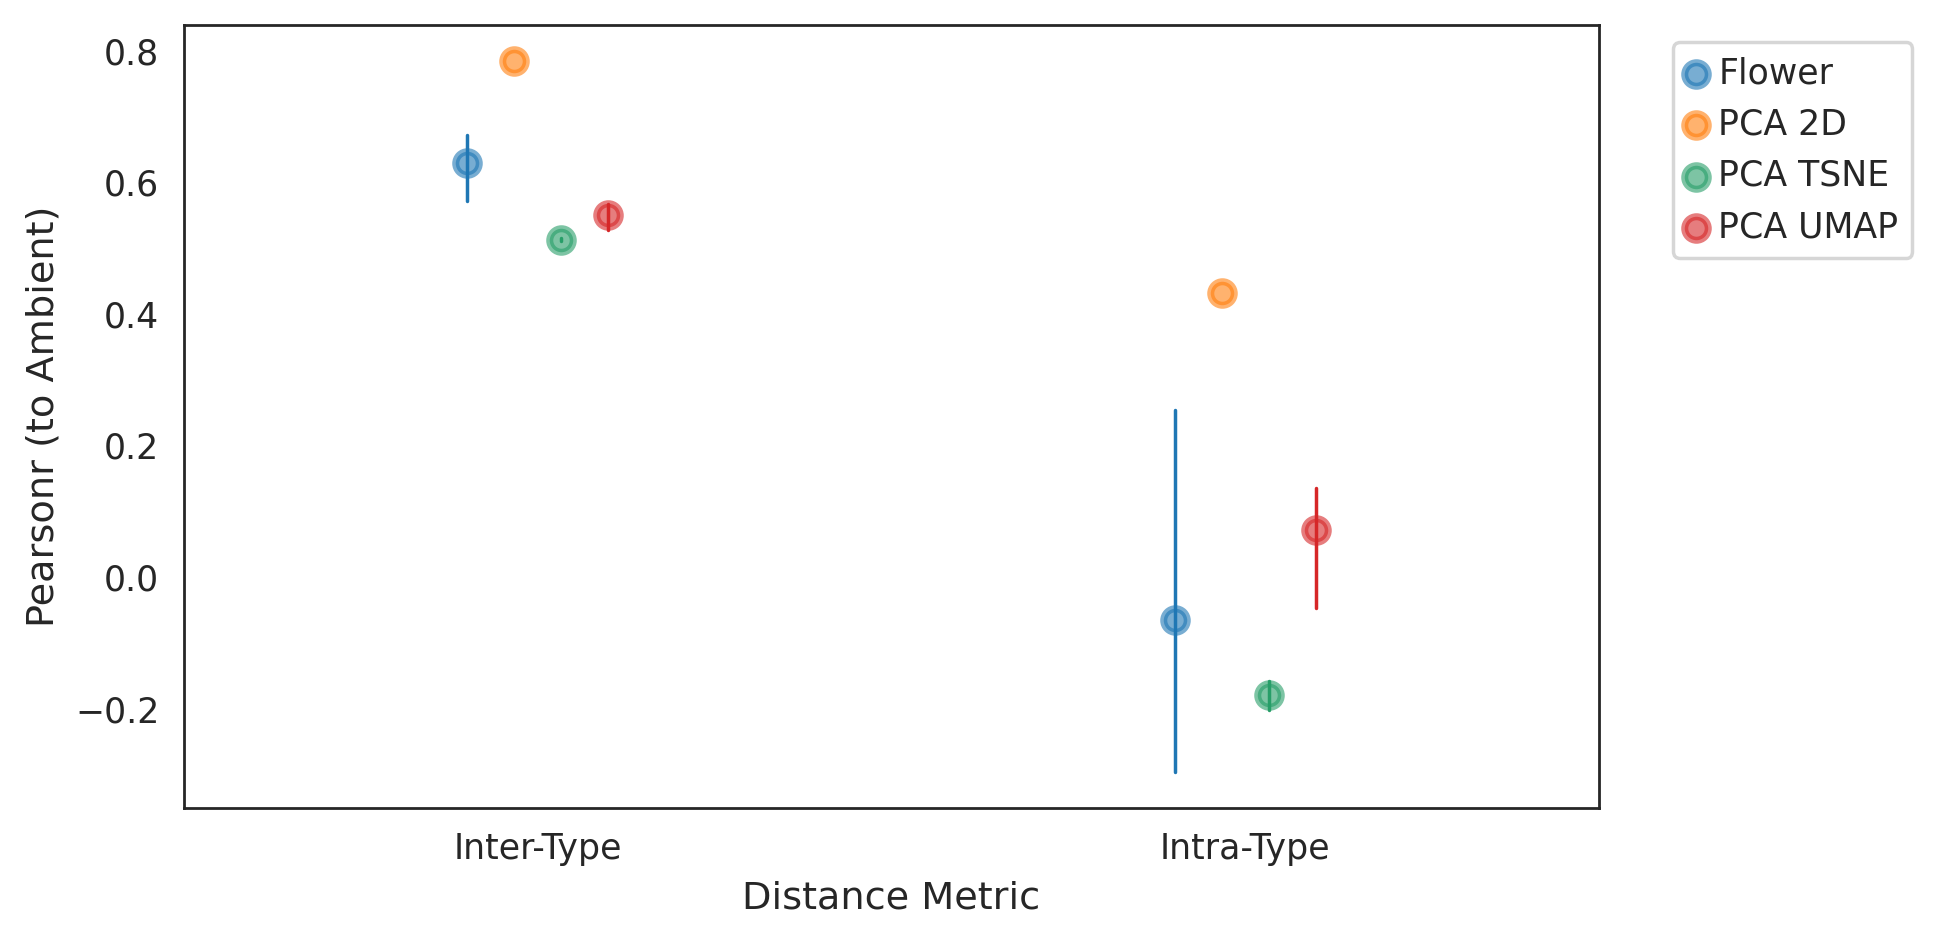

In [40]:
plotLatentStats(subDistAllVals, axisFontSize = 11, tickFontSize = 10,dodge=0.2,)

Compare Elephant Embedding Accuracy

In [60]:
latentLab

['Flower',
 'Flower',
 'Flower',
 'Flower',
 'Flower',
 'PCA 50D',
 'PCA 2D',
 'PCA TSNE',
 'PCA UMAP',
 'PCA densSNE',
 'PCA densMAP',
 'PCA 50D',
 'PCA 2D',
 'PCA TSNE',
 'PCA UMAP',
 'PCA densSNE',
 'PCA densMAP',
 'PCA 50D',
 'PCA 2D',
 'PCA TSNE',
 'PCA UMAP',
 'PCA densSNE',
 'PCA densMAP',
 'PCA 50D',
 'PCA 2D',
 'PCA TSNE',
 'PCA UMAP',
 'PCA densSNE',
 'PCA densMAP',
 'PCA 50D',
 'PCA 2D',
 'PCA TSNE',
 'PCA UMAP',
 'PCA densSNE',
 'PCA densMAP']

In [59]:
latents = latents[10:]
latentLab = latentLab[10:]
latentType = latentType[10:]

In [41]:
latents = el + latents

latentLab = elLab + latentLab

latentType = elType + latentType


In [42]:
allVals = getAllVars(latents,latentLab,latentType)
allVals = allVals[~allVals['Latent'].isin(['Flower','PCA 50D','Map'])]

In [43]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP','PCA 50D']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

In [44]:
toRemove = ['Intra-Sex','Inter-Sex']
subDistAllVals = subAllVals[~subAllVals['Distance'].isin(toRemove)]

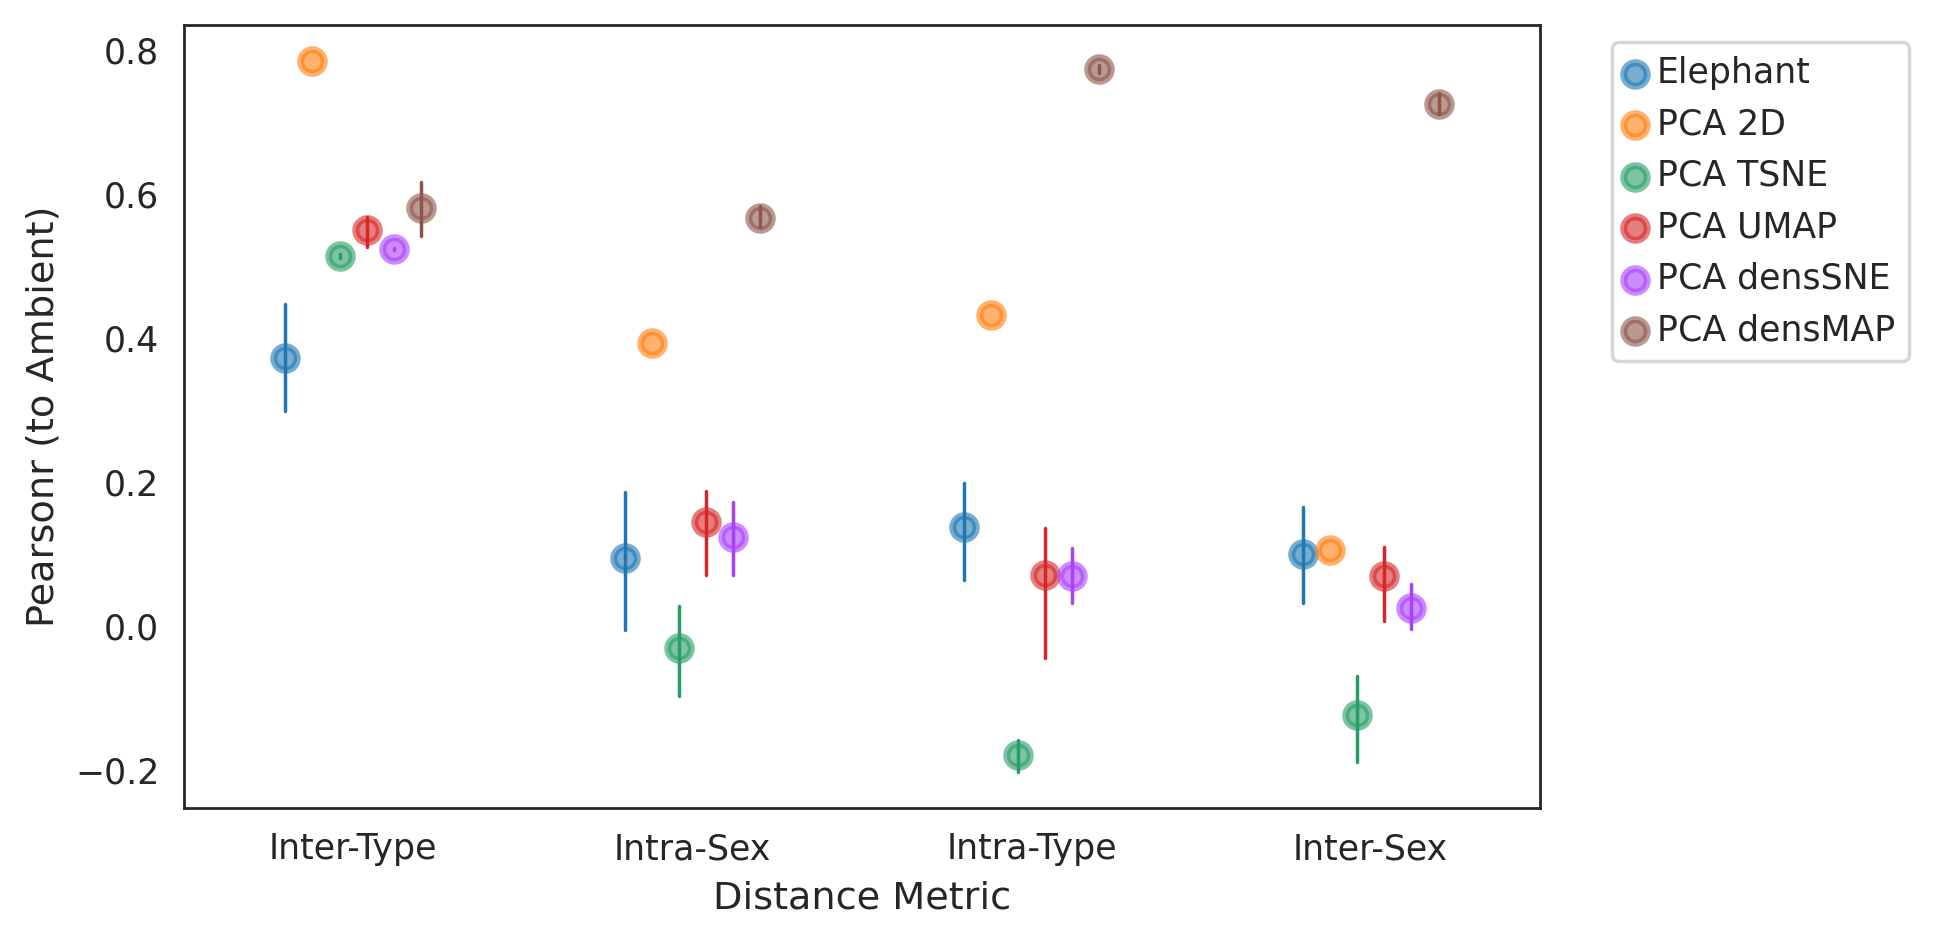

In [45]:
plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10) #0.15

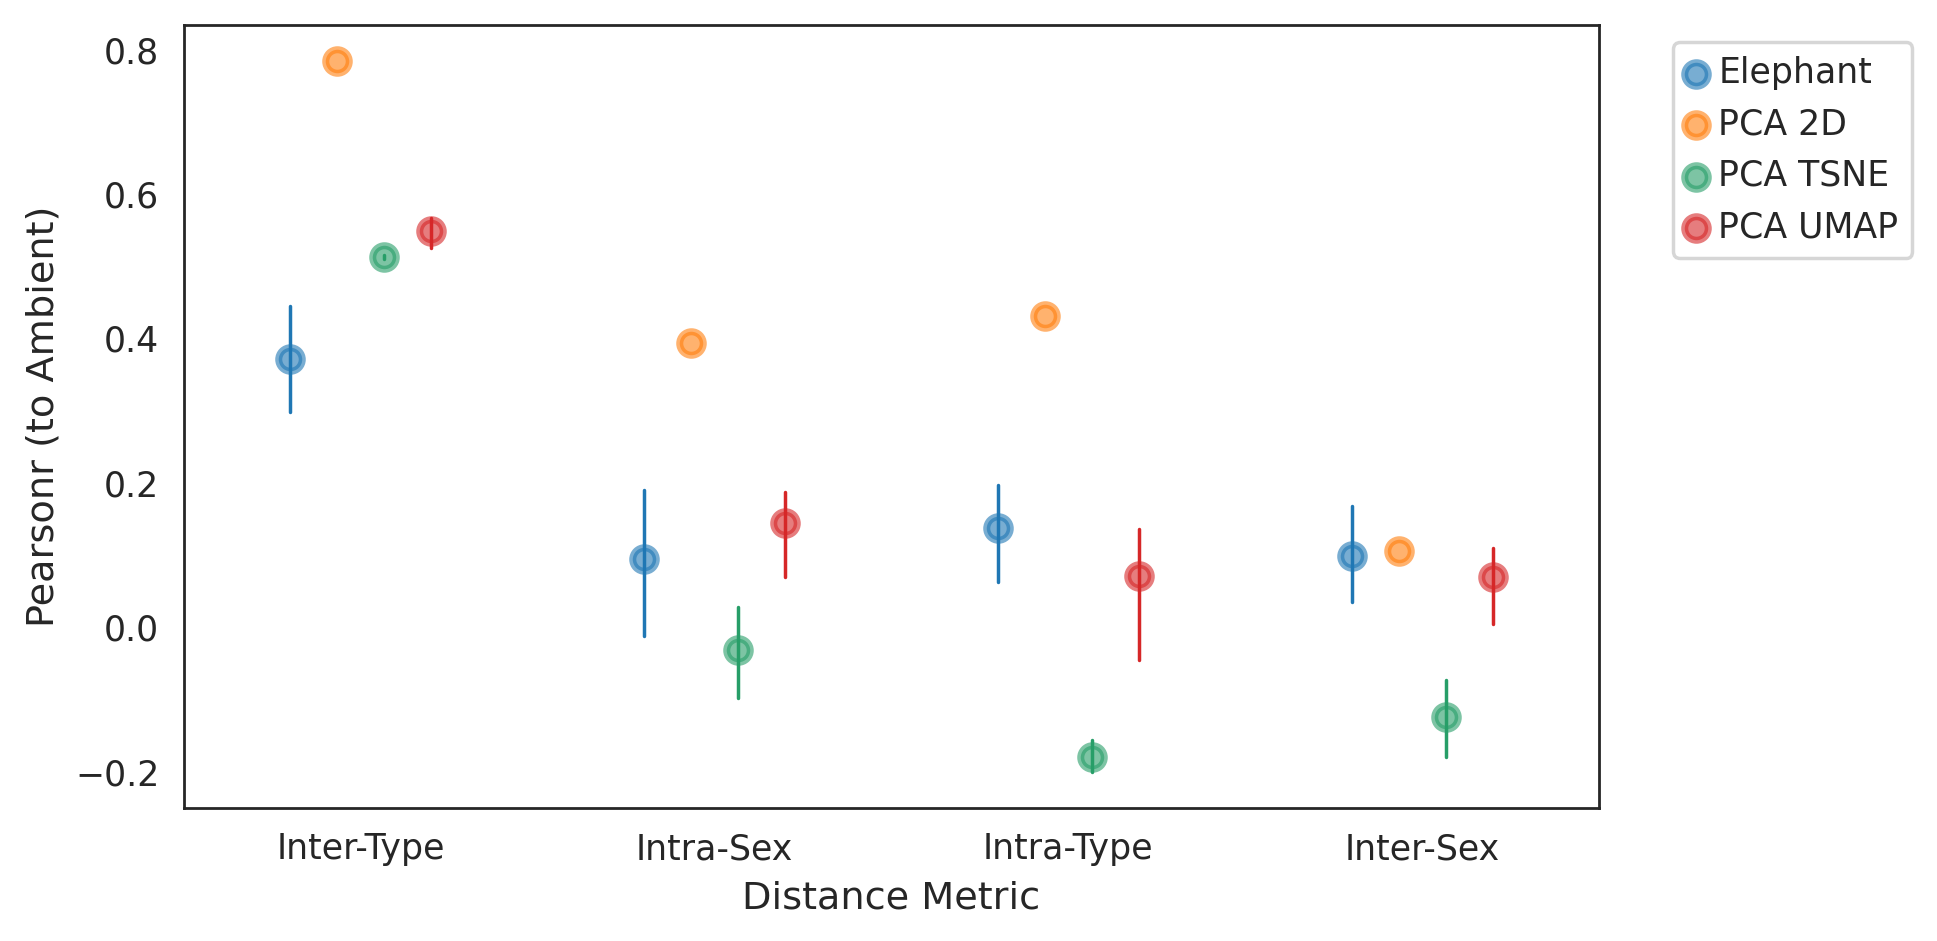

In [46]:
plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10)

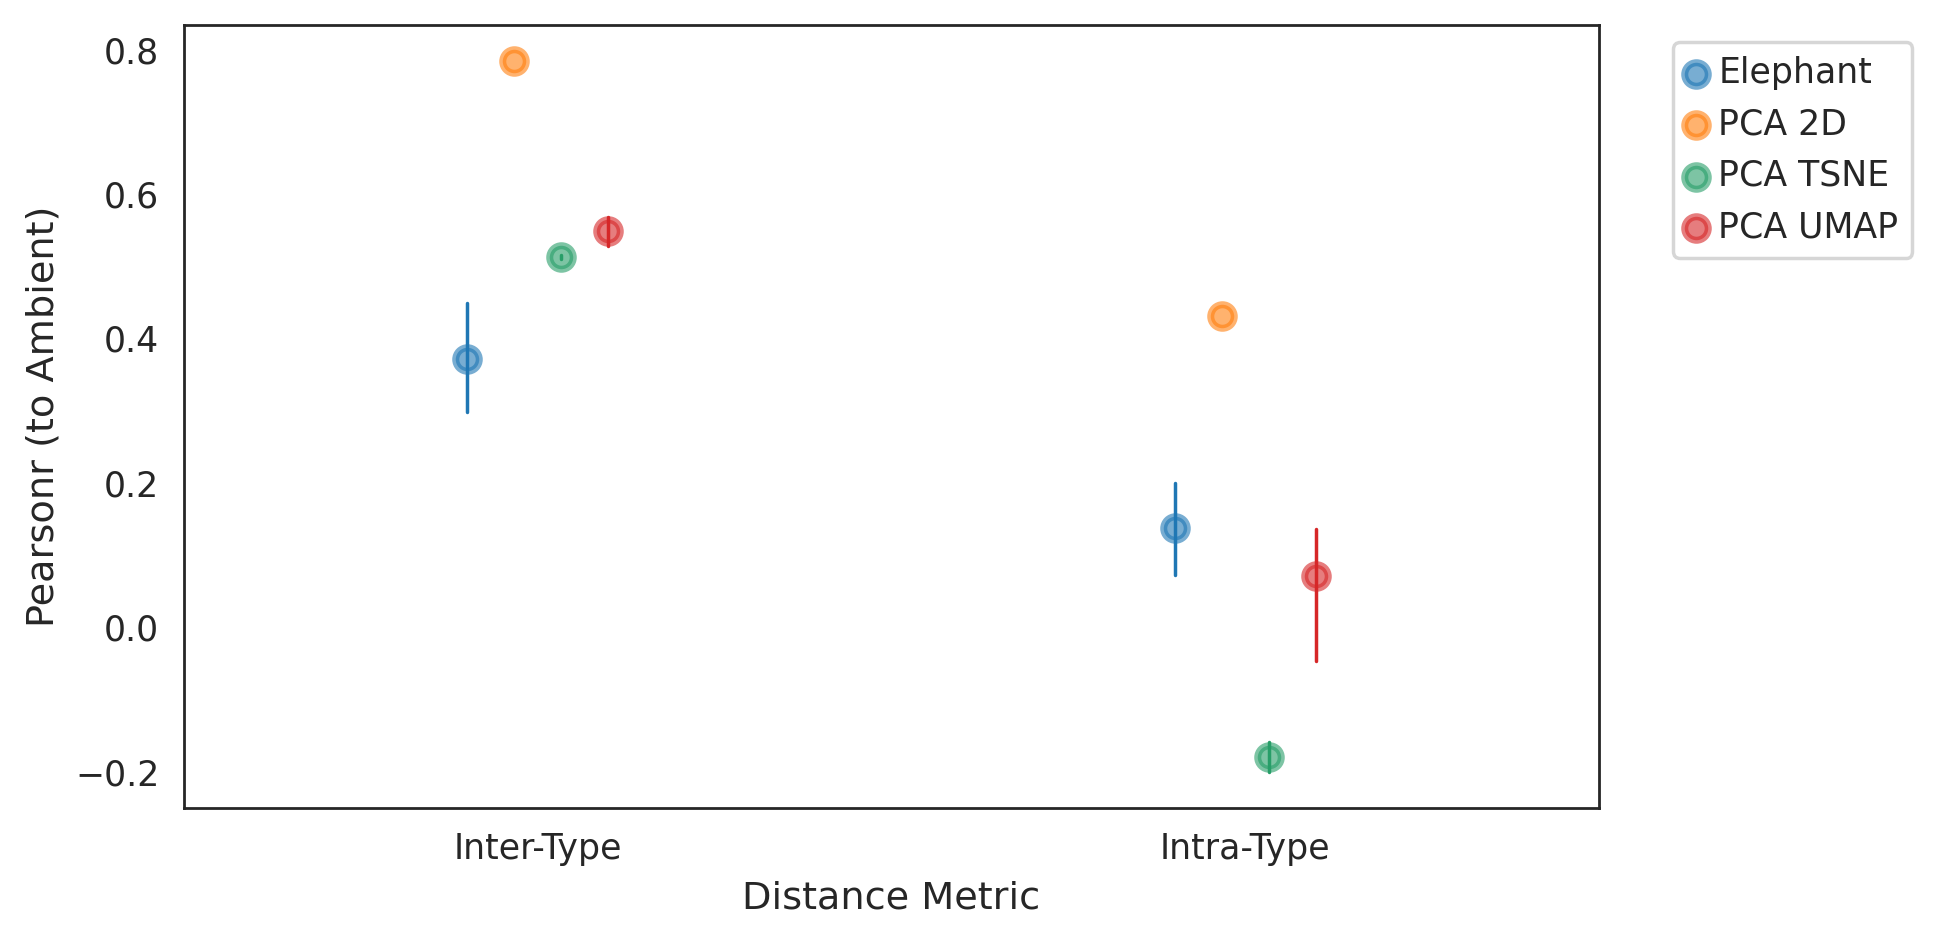

In [47]:
plotLatentStats(subDistAllVals, axisFontSize = 11, tickFontSize = 10,dodge=0.2,)

In [52]:
from google.colab import files

allVals.to_csv('smartSeqElVals.csv')
#files.download('smartSeqElVals.csv')

Compare map embedding

In [48]:
latents = map + latents #[1:]

latentLab = mapLab + latentLab #[1:]

latentType = mapType + latentType #[1:]

In [49]:
allVals = getAllVars(latents,latentLab,latentType)
allVals = allVals[~allVals['Latent'].isin(['Elephant','Flower','PCA 50D'])]

In [50]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP','PCA 50D']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

In [51]:
toRemove = ['Intra-Sex','Inter-Sex']
subDistAllVals = subAllVals[~subAllVals['Distance'].isin(toRemove)]

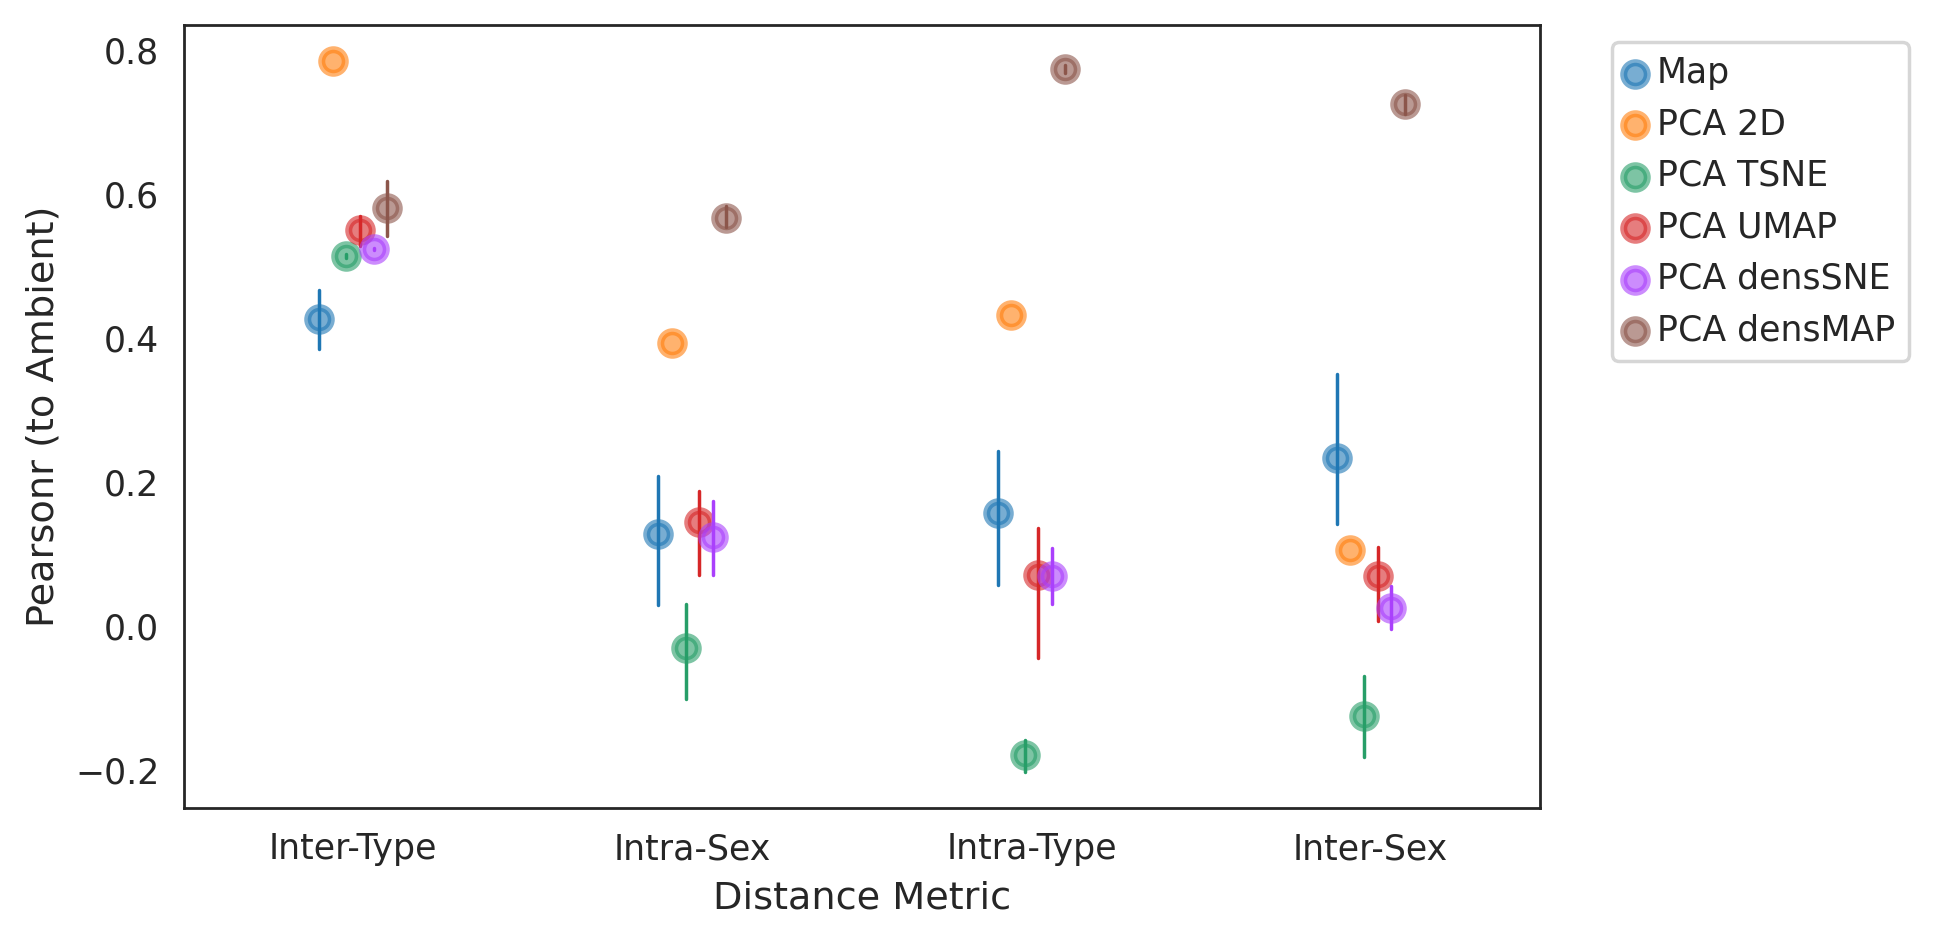

In [52]:
plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, dodge=0.2) #0.44 ok 

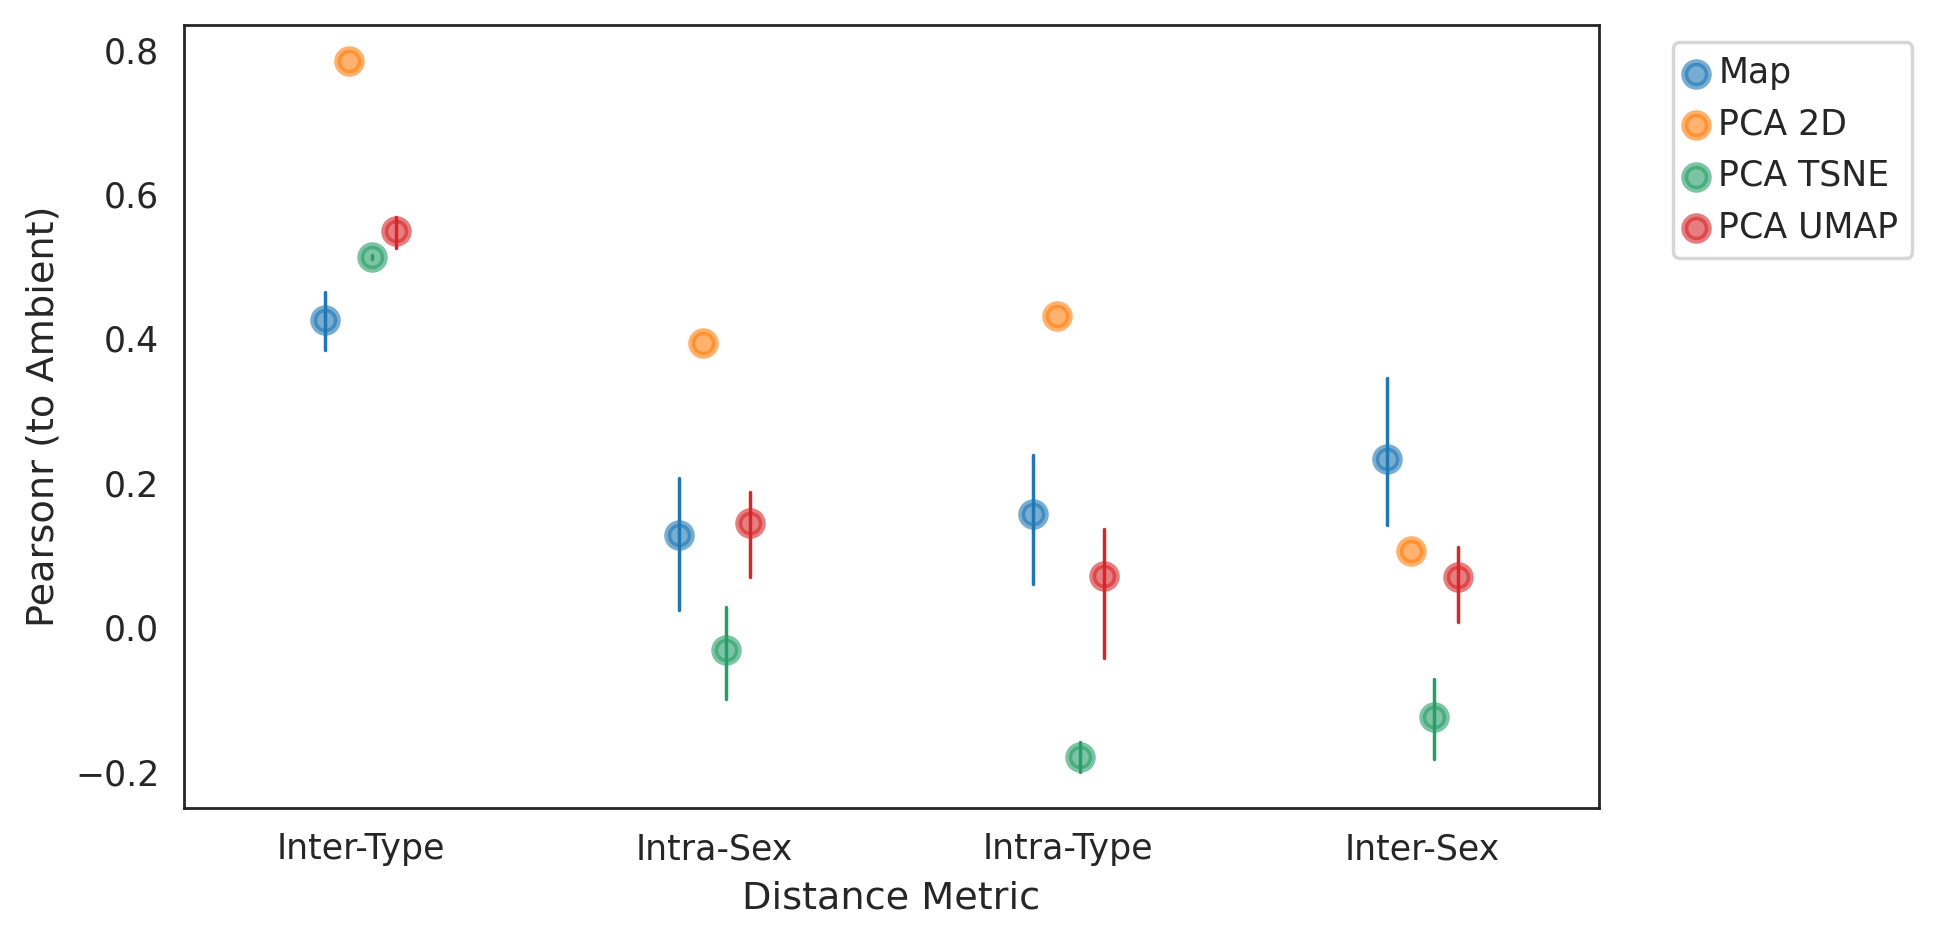

In [53]:
plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10, dodge=0.2)

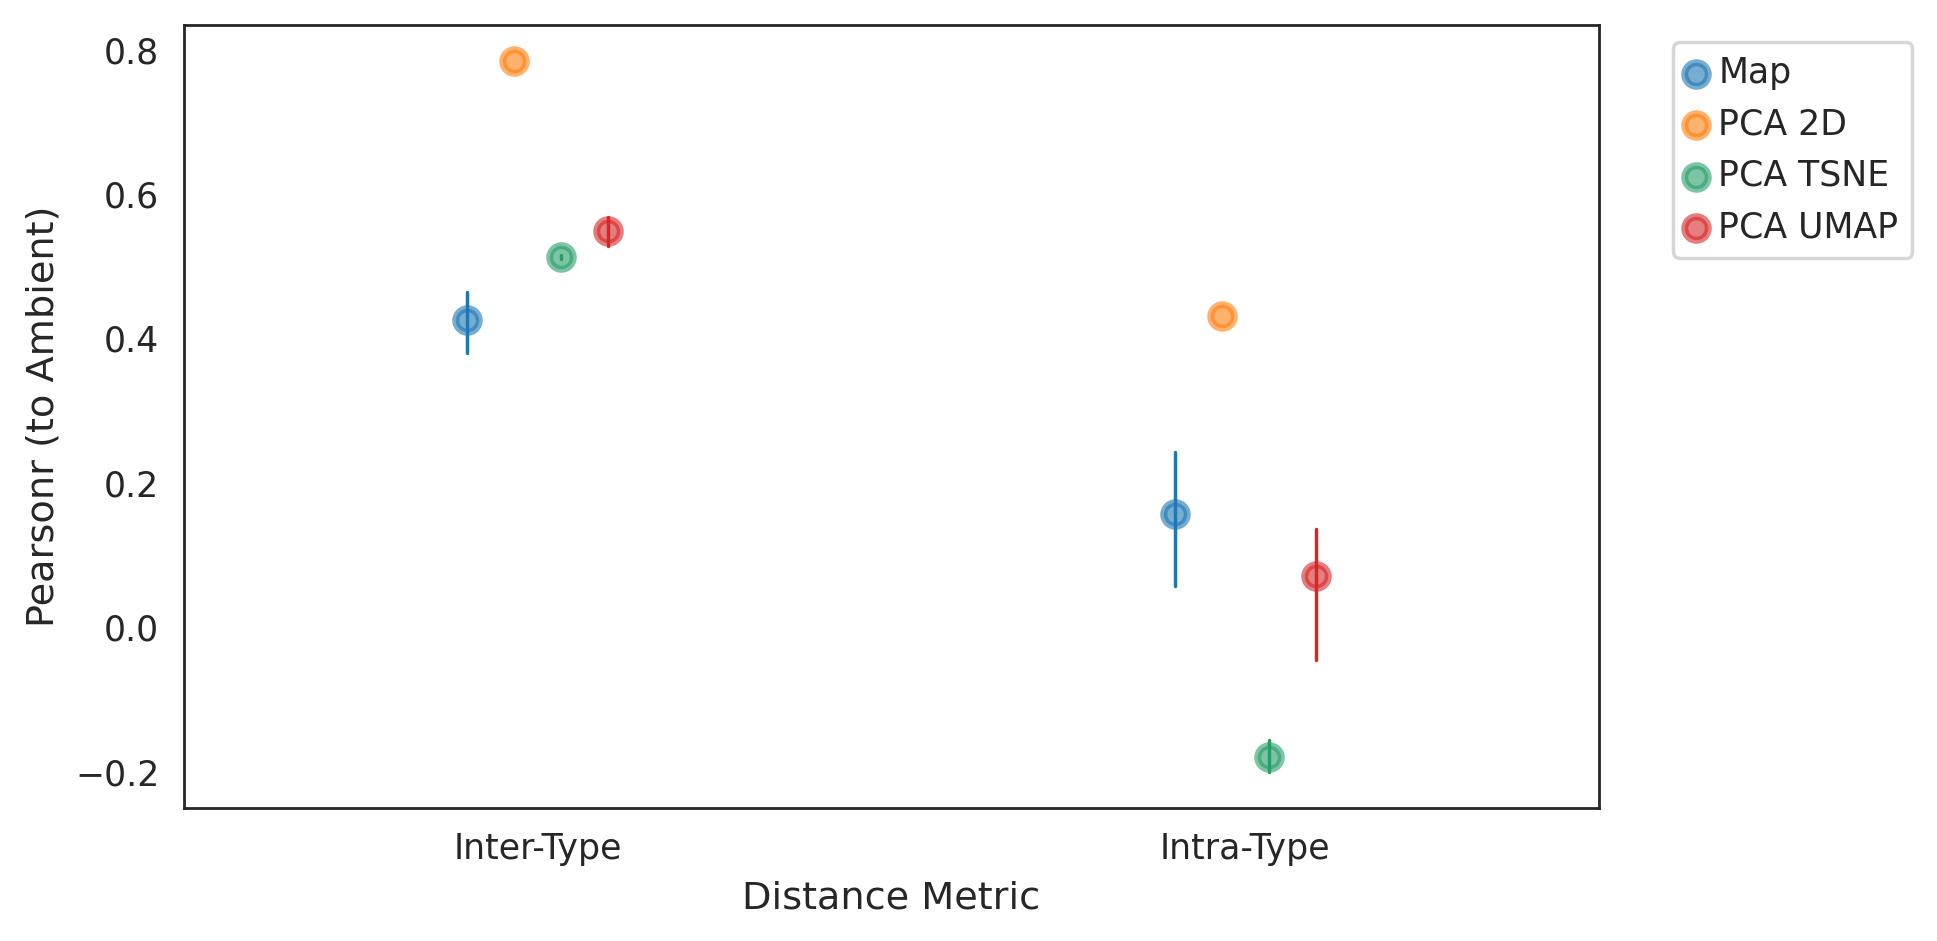

In [54]:
plotLatentStats(subDistAllVals, axisFontSize = 11, tickFontSize = 10, dodge=0.2)

In [55]:
allVals = getAllVars(latents,latentLab,latentType)

In [56]:

from google.colab import files

allVals.to_csv('smartElVals.csv')


In [57]:
files.download('smartElVals.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>